## Contextualizing variant calls by local identity 

In [2]:
import pandas as pd
from pathlib import Path
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Load in all pairs df 

# Directory containing CSV files
pairwise_dist_dir = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df = pd.read_csv(f, header=None,names=["sample1", "sample2", "direct_pairwise_dist","chr"])
    df["chr"] = chr_val
    all_dfs.append(df)

# Combine into one dataframe
all_pairs_dist_df = pd.concat(all_dfs, ignore_index=True)

all_pairs_dist_df["sample_pair"] = (
    all_pairs_dist_df[["sample1", "sample2"]]
    .apply(lambda x: "_".join(sorted(x)), axis=1)
)

all_pairs_dist_df.head()

sample1    sample2  direct_pairwise_dist   chr          sample_pair
0  HG03098.1  HG03784.1              0.942968  chr6  HG03098.1_HG03784.1
1  HG03098.1  NA20752.2              0.974936  chr6  HG03098.1_NA20752.2
2  HG01978.2  NA19835.1              0.999883  chr6  HG01978.2_NA19835.1
3  HG00741.1  NA18522.1              0.999869  chr6  HG00741.1_NA18522.1
4  HG00408.1  HG01496.1              0.606856  chr6  HG00408.1_HG01496.1

In [5]:
# Get list of sample pairs with dist < 0.2 
all_pairs_dist_df["sample_pair"] = (
    all_pairs_dist_df[["sample1", "sample2"]]
    .apply(lambda x: "_".join(sorted(x)), axis=1)
)

# Subset to distances < 0.2
allowed_pairs = set(
    all_pairs_dist_df.loc[all_pairs_dist_df["direct_pairwise_dist"] < 0.2, "sample_pair"]
)

### Starting with all SNVs (unfiltered)

In [5]:
base_path = Path("/private/groups/patenlab/mira/centrolign/analysis/CDR_variant_regression/SNVs_pairwise_raw_midpoint_aln_bases/")

# BED column names as given
columns = [
    "contig",
    "start",
    "end",
    "local_identity",
    "CDR_dist",
    "SNV_count1",
    "SNV_count2",
    "windowsize",
    "SNV_rate",
    "aligned_bases"
]

dfs = []

for chr_dir in base_path.glob("chr*"):
    if not chr_dir.is_dir():
        continue

    chr_name = chr_dir.name

    for bed_file in chr_dir.glob("*.bed"):
        # Extract sample names
        name_part = bed_file.name.split(".aligned_bases.bed")[0]
        sample1, sample2 = name_part.split("_", 1)
        sample_pair = "_".join(sorted([sample1, sample2]))

        # Skip pairs not in allowed set
        if sample_pair not in allowed_pairs:
            continue

        df = pd.read_csv(
            bed_file,
            sep="\t",
            header=None,
            names=columns,
        )

        df["chr"] = chr_name
        df["sample1"] = sample1
        df["sample2"] = sample2
        df["sample_pair"] = sample_pair
        
        df = df.drop(columns=["SNV_count2", "windowsize"])

        dfs.append(df)

# Combine only the filtered data
all_snvs_df = pd.concat(dfs, ignore_index=True)


In [6]:
all_snvs_df.head()

contig     start       end  local_identity  CDR_dist  \
0  HG00738#1#CM086650.1  50756450  50761449           97.59   1155047   
1  HG00738#1#CM086650.1  50761450  50766449           96.86   1150047   
2  HG00738#1#CM086650.1  50766450  50771449           96.66   1145047   
3  HG00738#1#CM086650.1  50771450  50776449           96.49   1140047   
4  HG00738#1#CM086650.1  50776450  50781449           97.00   1135047   

   SNV_count1  SNV_rate  aligned_bases    chr    sample1    sample2  \
0           0    0.0000           4999  chr11  HG00344.2  HG00738.1   
1           2    0.0004           4999  chr11  HG00344.2  HG00738.1   
2           0    0.0000           4999  chr11  HG00344.2  HG00738.1   
3           2    0.0004           4999  chr11  HG00344.2  HG00738.1   
4           6    0.0012           4999  chr11  HG00344.2  HG00738.1   

           sample_pair  
0  HG00344.2_HG00738.1  
1  HG00344.2_HG00738.1  
2  HG00344.2_HG00738.1  
3  HG00344.2_HG00738.1  
4  HG00344.2_HG00738.1

In [21]:
## Add SNV rate over aligned bases 

all_snvs_df["SNV_rate_aln"]=all_snvs_df["SNV_count1"] / all_snvs_df["aligned_bases"]

# ----------------------------
# Filter windows with <20% aligned bases
# ----------------------------
all_snvs_df["window_size"] = all_snvs_df["end"] - all_snvs_df["start"]
all_snvs_df["aligned_fraction"] = all_snvs_df["aligned_bases"] / all_snvs_df["window_size"]

all_snvs_df = all_snvs_df[all_snvs_df["aligned_fraction"] >= 0.2].copy()


/data/tmp/ipykernel_2801315/605563400.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  genome_stats = all_snvs_df.groupby('identity_bin').agg(


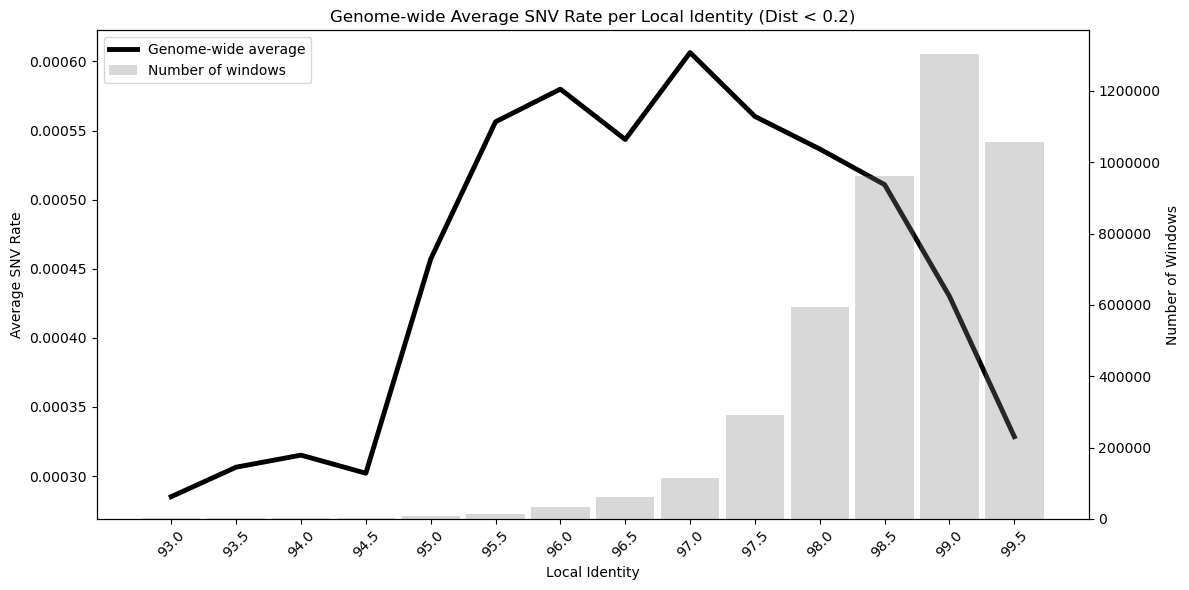

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create bins from 90 to 100 in steps of 0.5
bins = np.arange(93, 100.5, 0.5)
bin_edges = bins[:-1]  # left edges

# Add identity_bin (keep intervals for grouping)
all_snvs_df['identity_bin'] = pd.cut(
    all_snvs_df['local_identity'],
    bins=bins,
    include_lowest=True
)

# Genome-wide statistics per bin
genome_stats = all_snvs_df.groupby('identity_bin').agg(
    SNV_rate_avg=('SNV_rate_aln', 'mean'),
    window_count=('SNV_rate_aln', 'count')
).reset_index()

# Convert Interval → numeric (left bin edge)
genome_stats['bin_left'] = genome_stats['identity_bin'].apply(lambda x: x.left)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Primary y-axis: genome-wide average SNV rate
ax.plot(
    genome_stats['bin_left'],
    genome_stats['SNV_rate_avg'],
    color='black',
    linewidth=3.5,
    label='Genome-wide average'
)

ax.set_xlabel('Local Identity')
ax.set_ylabel('Average SNV Rate')
ax.grid(False)

# Secondary y-axis: number of windows per bin
ax2 = ax.twinx()
ax2.bar(
    genome_stats['bin_left'],
    genome_stats['window_count'],
    width=0.45,
    alpha=0.3,
    color='gray',
    label='Number of windows'
)
ax2.set_ylabel('Number of Windows')
ax2.grid(False)
ax2.ticklabel_format(axis='y', style='plain')
ax2.get_yaxis().get_offset_text().set_visible(False)

# X-axis ticks: bin edges only
ax.set_xticks(bin_edges)
ax.set_xticklabels([str(b) for b in bin_edges], rotation=45)

# Title
ax.set_title(
    'Genome-wide Average SNV Rate per Local Identity (Dist < 0.2)'
)

# Legend (combined)
lines, labels1 = ax.get_legend_handles_labels()
bars, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + bars, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()



### Genome Wide SNVs with per-chrom lines - fixed windows

/data/tmp/ipykernel_2801315/4280485060.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['chr', 'identity_bin'])
/data/tmp/ipykernel_2801315/4280485060.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('identity_bin')


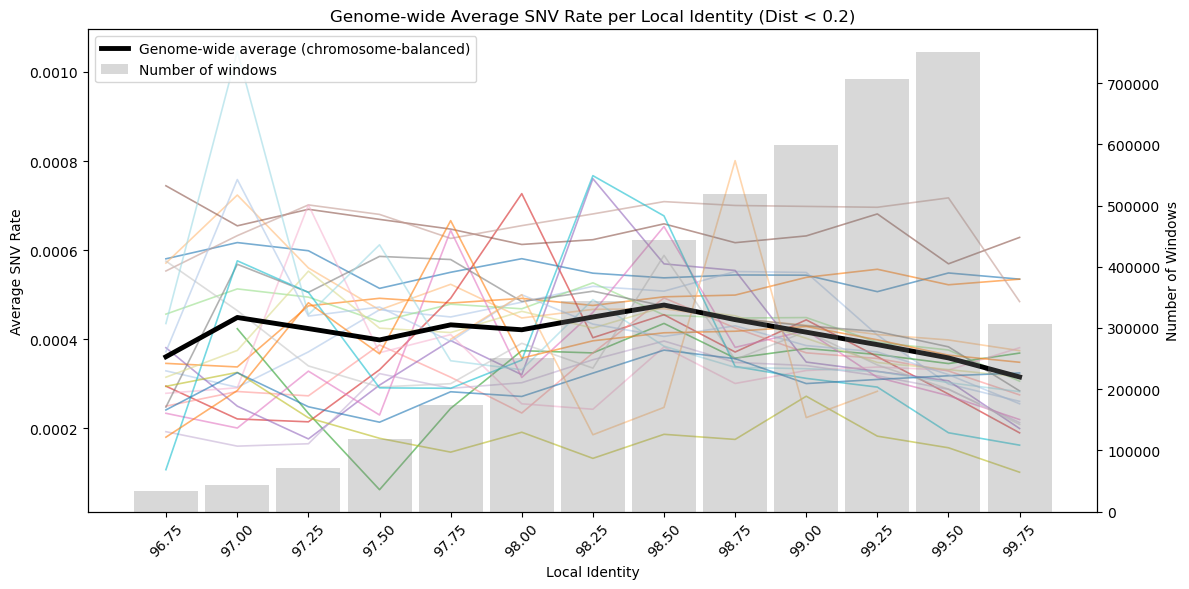

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Define bins based on data
# ----------------------------
bin_size = 0.25
lower_bound = 96.75

max_identity = np.nanmax(all_snvs_df['local_identity'].values)
max_identity_rounded = np.ceil(max_identity / bin_size) * bin_size

bins = np.arange(lower_bound, max_identity_rounded + bin_size, bin_size)
bin_width = bins[1] - bins[0]

# ----------------------------
# Assign identity bins
# ----------------------------
all_snvs_df['identity_bin'] = pd.cut(
    all_snvs_df['local_identity'],
    bins=bins,
    include_lowest=True
)

# ----------------------------
# Compute per-chromosome statistics
# ----------------------------
chrom_bin_stats = (
    all_snvs_df
    .groupby(['chr', 'identity_bin'])
    .agg(
        SNV_rate_chr_avg=('SNV_rate_aln', 'mean'),
        window_count_chr=('SNV_rate_aln', 'count')
    )
    .reset_index()
)

# Convert Interval → numeric left edge (force float)
chrom_bin_stats['bin_left'] = chrom_bin_stats['identity_bin'].apply(lambda x: x.left).astype(float)
chrom_bin_stats['bin_center'] = chrom_bin_stats['bin_left'] + bin_width / 2




# ----------------------------
# Compute genome-wide average (chromosome-balanced)
# ----------------------------
genome_stats = (
    chrom_bin_stats
    .groupby('identity_bin')
    .agg(
        SNV_rate_avg=('SNV_rate_chr_avg', 'mean'),  # equal-weight chrom mean
        n_chroms=('SNV_rate_chr_avg', 'count'),
        window_count=('window_count_chr', 'sum')    # total windows (for bars)
    )
    .reset_index()
)

genome_stats['bin_left'] = genome_stats['identity_bin'].apply(lambda x: x.left).astype(float)
genome_stats['bin_center'] = genome_stats['bin_left'] + bin_width / 2

# ----------------------------
# Chromosome colors
# ----------------------------
chroms = sorted(chrom_bin_stats['chr'].unique())
cmap = plt.get_cmap('tab20')  # good for ~20 chromosomes
chrom_colors = {chrom: cmap(i % cmap.N) for i, chrom in enumerate(chroms)}

# ----------------------------
# Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(12, 6))

# Per-chromosome lines (background)
for chrom, df_chrom in chrom_bin_stats.groupby('chr'):
    ax.plot(
        df_chrom['bin_center'],
        df_chrom['SNV_rate_chr_avg'],
        color=chrom_colors[chrom],
        linewidth=1.2,
        alpha=0.6,
        zorder=1
    )

# Genome-wide average line
ax.plot(
    genome_stats['bin_center'],
    genome_stats['SNV_rate_avg'],
    color='black',
    linewidth=3.5,
    label='Genome-wide average (chromosome-balanced)',
    zorder=3
)

ax.set_xlabel('Local Identity')
ax.set_ylabel('Average SNV Rate')
ax.grid(False)

# Secondary y-axis: number of windows per bin
ax2 = ax.twinx()
ax2.bar(
    genome_stats['bin_center'],  # center bars under lines
    genome_stats['window_count'],
    width=0.9 * bin_width,
    align='center',
    alpha=0.3,
    color='gray',
    label='Number of windows',
    zorder=0
)
ax2.set_ylabel('Number of Windows')
ax2.grid(False)
ax2.ticklabel_format(axis='y', style='plain')
ax2.get_yaxis().get_offset_text().set_visible(False)

# X-axis ticks at bin centers
ax.set_xticks(genome_stats['bin_center'])
ax.set_xticklabels(
    [f"{b:.2f}" for b in genome_stats['bin_left']],
    rotation=45
)

# Title
ax.set_title('Genome-wide Average SNV Rate per Local Identity (Dist < 0.2)')

# Combined legend
lines, labels1 = ax.get_legend_handles_labels()
bars, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + bars, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()


/data/tmp/ipykernel_2801315/3000675998.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['chr', 'identity_bin'])


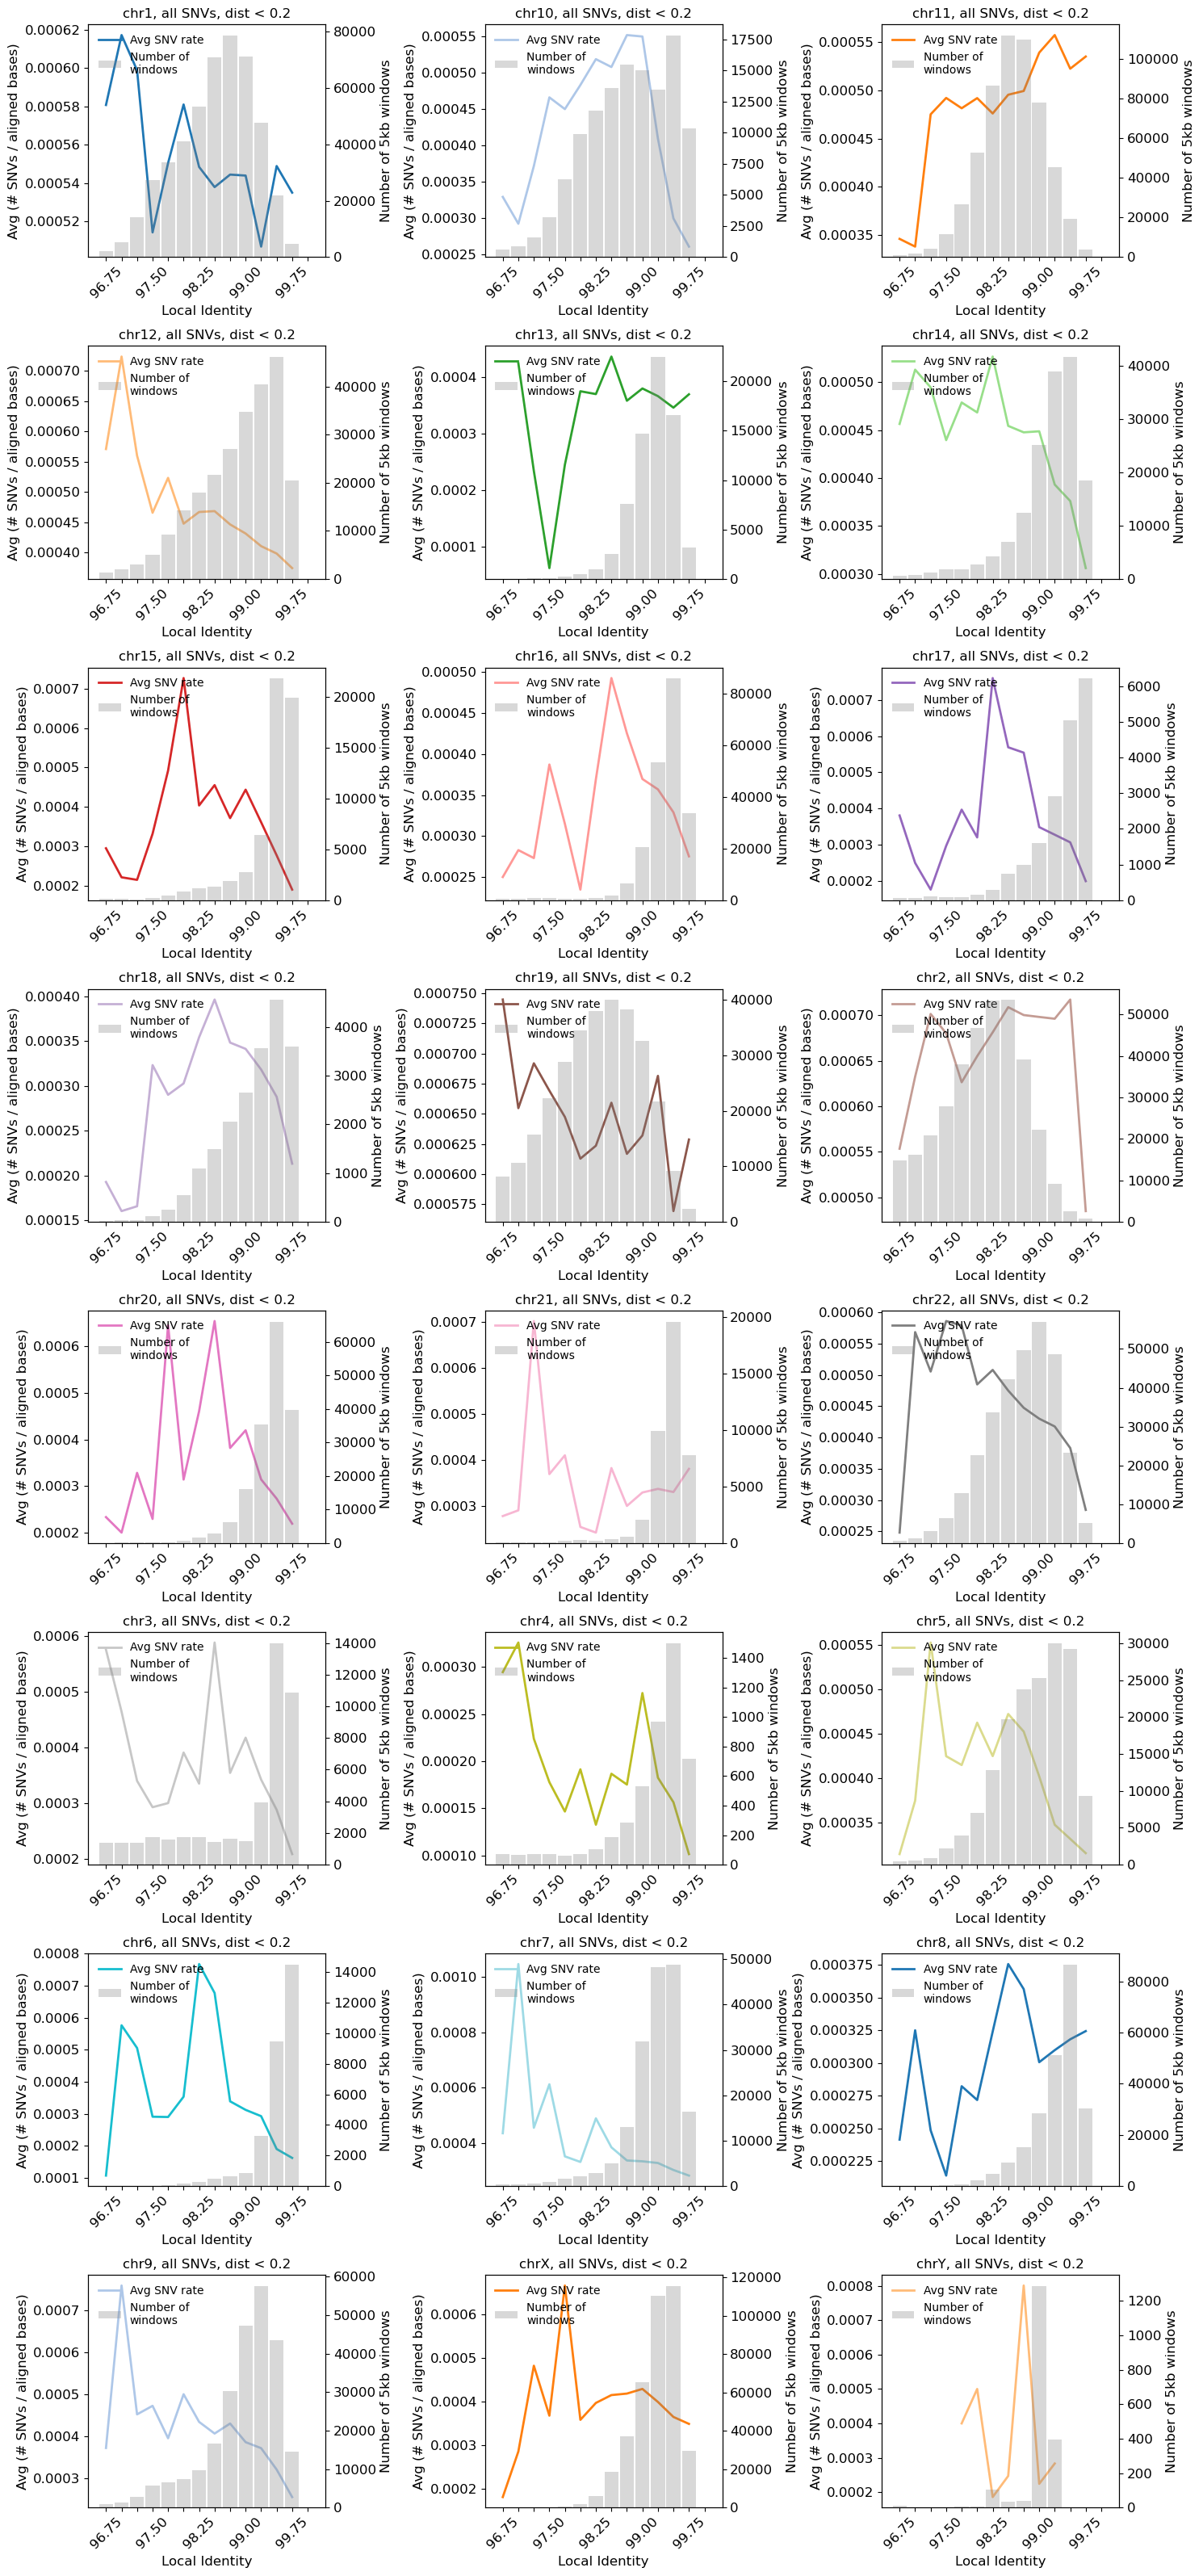

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Define bins
# ----------------------------
bins = np.arange(96.75, 100.5, 0.25)
bin_width = bins[1] - bins[0]
bin_left_edges = bins[:-1]

# ----------------------------
# Assign identity bins
# ----------------------------
all_snvs_df['identity_bin'] = pd.cut(
    all_snvs_df['local_identity'],
    bins=bins,
    include_lowest=True
)

# ----------------------------
# Per-chromosome averages
# ----------------------------
chrom_avg = (
    all_snvs_df
    .groupby(['chr', 'identity_bin'])
    .agg(
        SNV_rate_avg=('SNV_rate_aln', 'mean'),
        window_count=('SNV_rate_aln', 'count')
    )
    .reset_index()
)

# 🔑 FORCE numeric bin edges
chrom_avg['bin_left'] = chrom_avg['identity_bin'].apply(lambda x: x.left).astype(float)
chrom_avg['bin_center'] = chrom_avg['bin_left'] + bin_width / 2

# ----------------------------
# Plot layout
# ----------------------------
chromosomes = chrom_avg['chr'].unique()
n_chroms = len(chromosomes)

n_cols = 3
n_rows = int(np.ceil(n_chroms / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 5, n_rows * 4),
    sharey=False
)
axes = axes.flatten()

colors = plt.cm.tab20.colors
N = 3  # label every Nth bin

# ----------------------------
# Plot each chromosome
# ----------------------------
for i, chrom in enumerate(chromosomes):
    ax = axes[i]
    chrom_data = chrom_avg[chrom_avg['chr'] == chrom]

    # Line: bin centers
    l1, = ax.plot(
        chrom_data['bin_center'],
        chrom_data['SNV_rate_avg'],
        color=colors[i % len(colors)],
        linewidth=2,
        label='Avg SNV rate'
    )

    # Bars: centered on bins
    ax2 = ax.twinx()
    l2 = ax2.bar(
        chrom_data['bin_center'],
        chrom_data['window_count'],
        width=0.9 * bin_width,
        align='center',
        alpha=0.3,
        color='gray',
        label='Number of windows'
    )

    ax.set_ylabel('Avg (# SNVs / aligned bases)', fontsize=12)
    ax2.set_ylabel('Number of 5kb windows', fontsize=12)

    ax.grid(False)
    ax2.grid(False)

    # X ticks at bin centers, labels from left edge
    xticks = bin_left_edges + bin_width / 2
    tick_labels = [
        f"{bin_left_edges[j]:.2f}" if j % N == 0 else ''
        for j in range(len(bin_left_edges))
    ]

    ax.set_xticks(xticks)
    ax.set_xticklabels(tick_labels, rotation=45, fontsize=12)

    ax.tick_params(axis='both', labelsize=12)
    ax2.tick_params(axis='y', labelsize=12)

    ax.set_xlabel("Local Identity", fontsize=12)
    ax.set_title(f'{chrom}, all SNVs, dist < 0.2', fontsize=12)

    ax.legend(
        handles=[l1, l2],
        labels=['Avg SNV rate', 'Number of\nwindows'],
        loc='upper left',
        frameon=False
    )

# ----------------------------
# Remove empty subplots
# ----------------------------
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### SNVs - Plotting 95% per chrom

/data/tmp/ipykernel_2801315/693778336.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('identity_bin')
/data/tmp/ipykernel_2801315/693778336.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('identity_bin')
/data/tmp/ipykernel_2801315/693778336.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('identity_bin')
/data/tmp/ipykernel_2801315/693778336.py:42: FutureWarning: The default of o

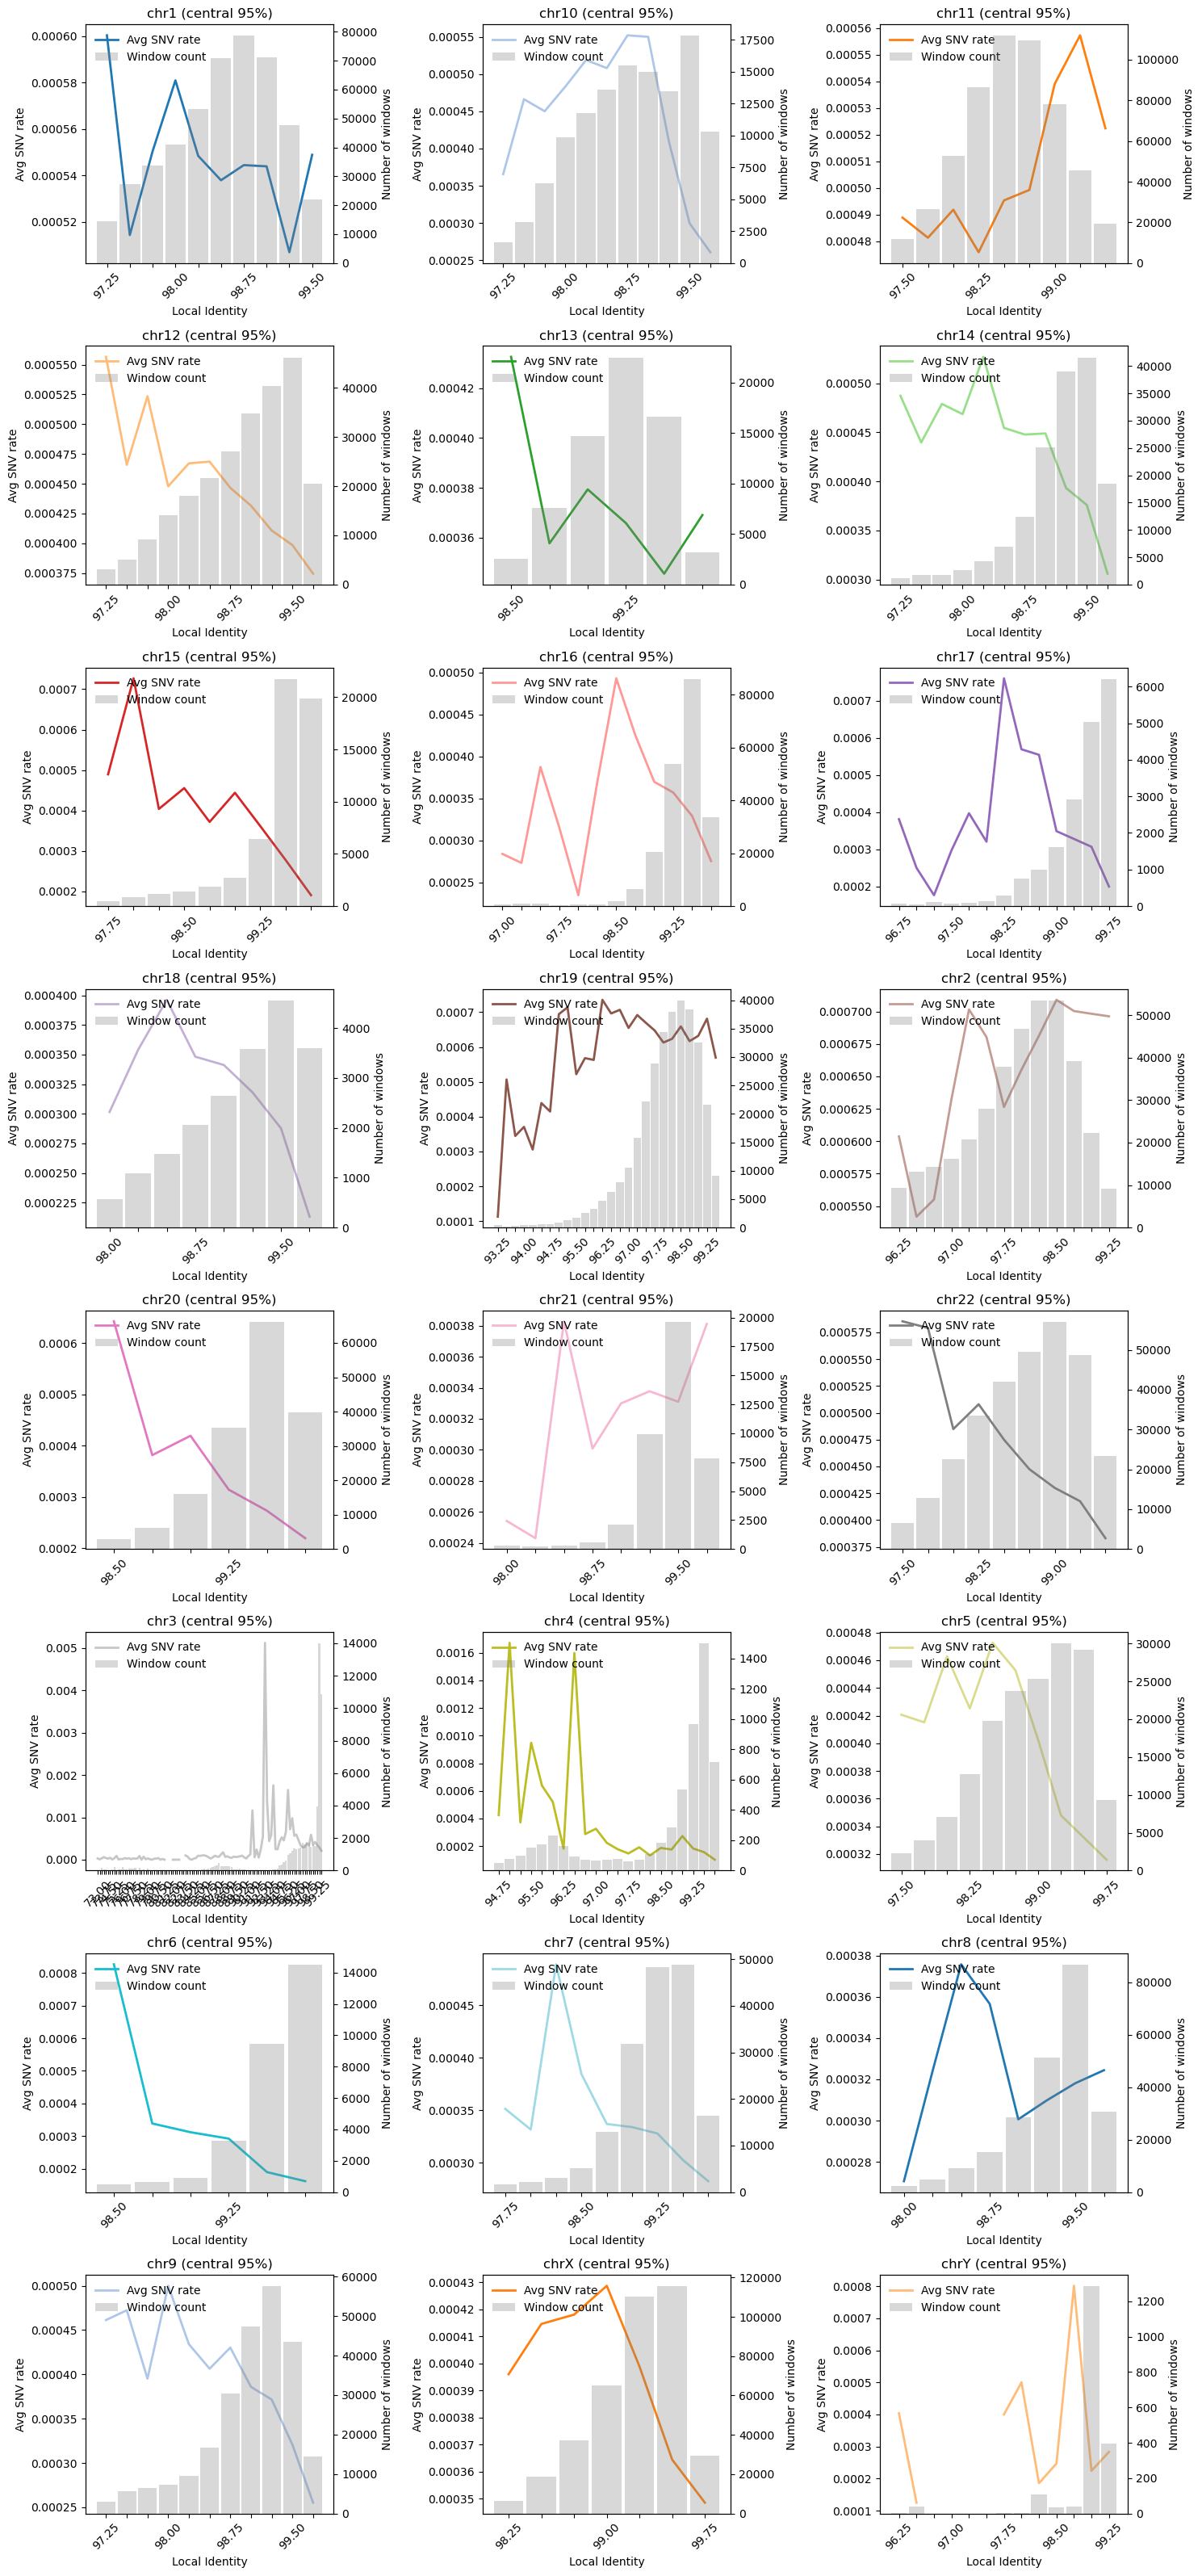

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Parameters
# ----------------------------
bin_size = 0.25
n_cols = 3
label_every = 3  # show every Nth x tick label

# ----------------------------
# Helper: bin + summarize one chromosome
# ----------------------------
def summarize_chrom_95(df_chrom, bin_size):
    # Compute 95% identity range for this chromosome
    low_q, high_q = np.nanpercentile(
        df_chrom['local_identity'].values,
        [2.5, 97.5]
    )

    lower = np.floor(low_q / bin_size) * bin_size
    upper = np.ceil(high_q / bin_size) * bin_size

    # Build bins
    bins = np.arange(lower, upper + bin_size, bin_size)

    # Assign bins
    df = df_chrom.copy()
    df['identity_bin'] = pd.cut(
        df['local_identity'],
        bins=bins,
        include_lowest=True
    )

    # Drop windows outside 95% range
    df = df.dropna(subset=['identity_bin'])

    # Aggregate
    out = (
        df
        .groupby('identity_bin')
        .agg(
            SNV_rate_avg=('SNV_rate_aln', 'mean'),
            window_count=('SNV_rate_aln', 'count')
        )
        .reset_index()
    )

    # Convert Interval → numeric positions (FORCE float)
    out['bin_left'] = out['identity_bin'].apply(lambda x: x.left).astype(float)
    out['bin_center'] = out['bin_left'] + bin_size / 2

    return out, bins

# ----------------------------
# Prepare per-chromosome summaries
# ----------------------------
chrom_results = {}

for chrom, df_chrom in all_snvs_df.groupby('chr'):
    if df_chrom['local_identity'].notna().sum() < 10:
        continue  # skip tiny chromosomes if any
    chrom_results[chrom] = summarize_chrom_95(df_chrom, bin_size)

chromosomes = list(chrom_results.keys())
n_chroms = len(chromosomes)
n_rows = int(np.ceil(n_chroms / n_cols))

# ----------------------------
# Plot
# ----------------------------
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 5, n_rows * 4),
    sharey=False
)
axes = axes.flatten()

colors = plt.cm.tab20.colors

for i, chrom in enumerate(chromosomes):
    ax = axes[i]
    chrom_df, bins = chrom_results[chrom]

    bin_width = bins[1] - bins[0]
    bin_left_edges = bins[:-1]

    # Line: average SNV rate
    l1, = ax.plot(
        chrom_df['bin_center'],
        chrom_df['SNV_rate_avg'],
        color=colors[i % len(colors)],
        linewidth=2
    )

    # Bars: window counts
    ax2 = ax.twinx()
    l2 = ax2.bar(
        chrom_df['bin_center'],
        chrom_df['window_count'],
        width=0.9 * bin_width,
        align='center',
        alpha=0.3,
        color='gray'
    )

    # X ticks (chrom-specific)
    xticks = bin_left_edges + bin_width / 2
    xtick_labels = [
        f"{bin_left_edges[j]:.2f}" if j % label_every == 0 else ''
        for j in range(len(bin_left_edges))
    ]

    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels, rotation=45)

    # Labels
    ax.set_xlabel('Local Identity')
    ax.set_ylabel('Avg SNV rate')
    ax2.set_ylabel('Number of windows')

    ax.set_title(f'{chrom} (central 95%)')

    ax.grid(False)
    ax2.grid(False)

    ax.legend(
        handles=[l1, l2],
        labels=['Avg SNV rate', 'Window count'],
        loc='upper left',
        frameon=False
    )

# Remove unused panels
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### SNVs - 95% WG, per chrom faceted

/data/tmp/ipykernel_2801315/2474491562.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['chr', 'identity_bin'])


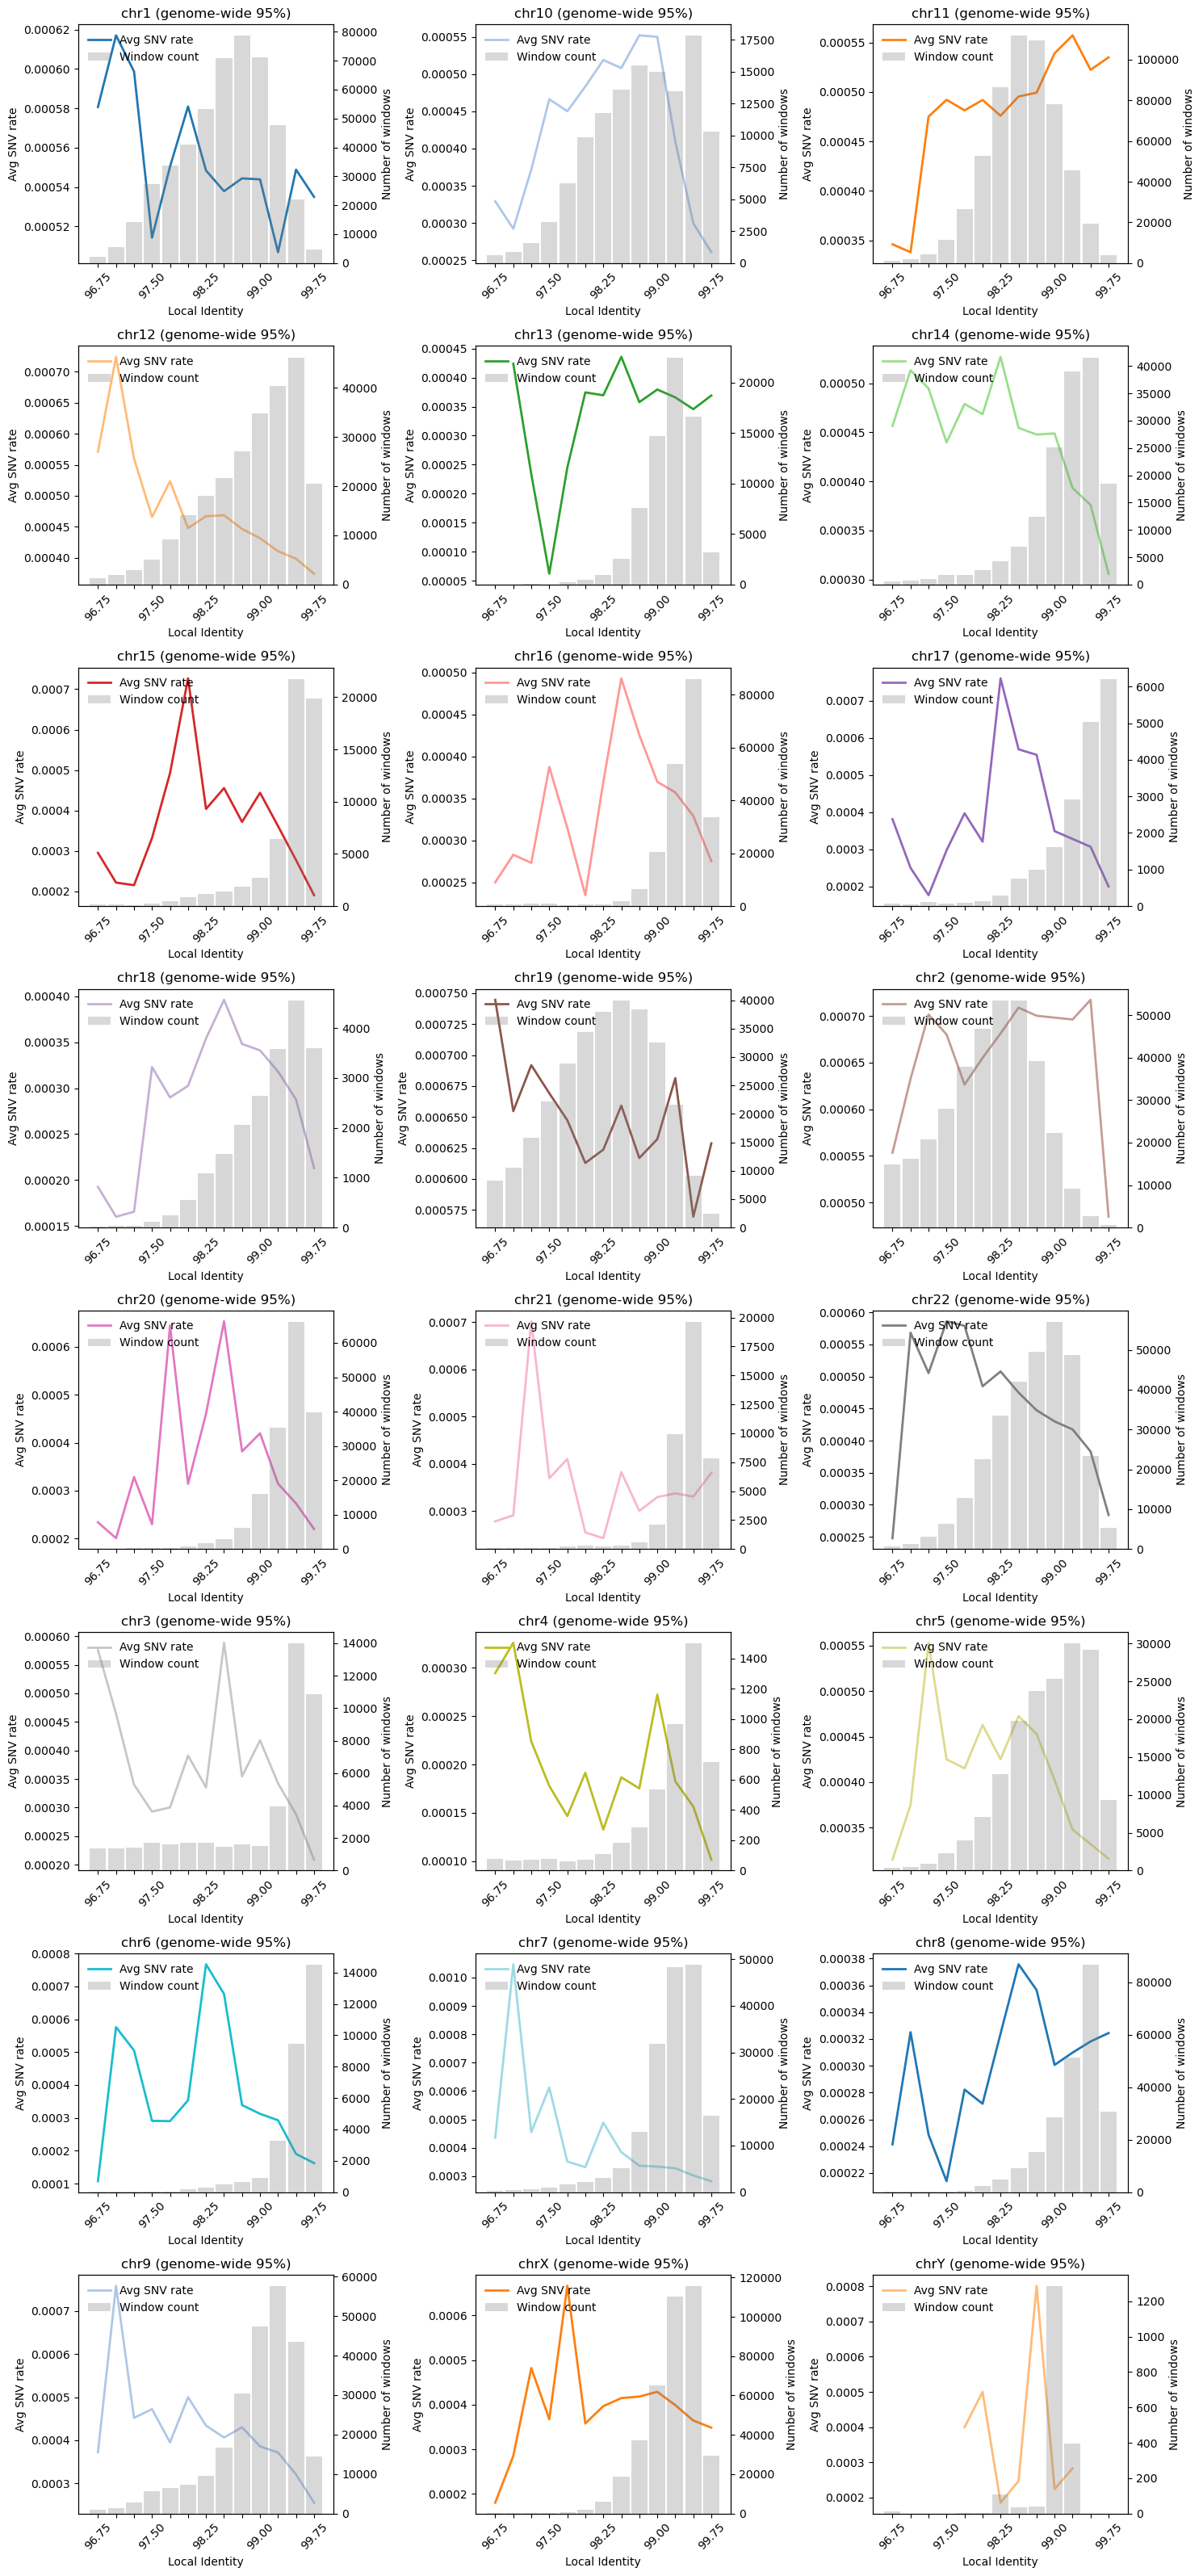

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Parameters
# ----------------------------
bin_size = 0.25
n_cols = 3
label_every = 3  # show every Nth x tick label

# ----------------------------
# Compute genome-wide 95% identity range
# ----------------------------
low_q, high_q = np.nanpercentile(
    all_snvs_df['local_identity'].values,
    [2.5, 97.5]
)

lower_bound = np.floor(low_q / bin_size) * bin_size
upper_bound = np.ceil(high_q / bin_size) * bin_size

bins = np.arange(lower_bound, upper_bound + bin_size, bin_size)
bin_width = bin_size
bin_left_edges = bins[:-1]
bin_centers = bin_left_edges + bin_width / 2

# ----------------------------
# Assign bins genome-wide
# ----------------------------
all_snvs_df['identity_bin'] = pd.cut(
    all_snvs_df['local_identity'],
    bins=bins,
    include_lowest=True
)

# Keep only windows inside genome-wide 95%
all_snvs_df_95 = all_snvs_df.dropna(subset=['identity_bin'])

# ----------------------------
# Per-chromosome aggregation (shared bins)
# ----------------------------
chrom_avg = (
    all_snvs_df_95
    .groupby(['chr', 'identity_bin'])
    .agg(
        SNV_rate_avg=('SNV_rate_aln', 'mean'),
        window_count=('SNV_rate_aln', 'count')
    )
    .reset_index()
)

# Convert Interval → numeric (force float)
chrom_avg['bin_left'] = (
    chrom_avg['identity_bin']
    .apply(lambda x: x.left)
    .astype(float)
)
chrom_avg['bin_center'] = chrom_avg['bin_left'] + bin_width / 2

# ----------------------------
# Faceted plotting setup
# ----------------------------
chromosomes = chrom_avg['chr'].unique()
n_chroms = len(chromosomes)
n_rows = int(np.ceil(n_chroms / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 5, n_rows * 4),
    sharey=False
)
axes = axes.flatten()

colors = plt.cm.tab20.colors

# ----------------------------
# Plot per chromosome
# ----------------------------
for i, chrom in enumerate(chromosomes):
    ax = axes[i]
    chrom_data = chrom_avg[chrom_avg['chr'] == chrom]

    # Line: average SNV rate
    l1, = ax.plot(
        chrom_data['bin_center'],
        chrom_data['SNV_rate_avg'],
        color=colors[i % len(colors)],
        linewidth=2
    )

    # Bars: number of windows
    ax2 = ax.twinx()
    l2 = ax2.bar(
        chrom_data['bin_center'],
        chrom_data['window_count'],
        width=0.9 * bin_width,
        align='center',
        alpha=0.3,
        color='gray'
    )

    # X ticks (shared across chroms)
    xtick_labels = [
        f"{bin_left_edges[j]:.2f}" if j % label_every == 0 else ''
        for j in range(len(bin_left_edges))
    ]

    ax.set_xticks(bin_centers)
    ax.set_xticklabels(xtick_labels, rotation=45)

    # Labels
    ax.set_xlabel('Local Identity')
    ax.set_ylabel('Avg SNV rate')
    ax2.set_ylabel('Number of windows')

    ax.set_title(f'{chrom} (genome-wide 95%)')

    ax.grid(False)
    ax2.grid(False)

    ax.legend(
        handles=[l1, l2],
        labels=['Avg SNV rate', 'Window count'],
        loc='upper left',
        frameon=False
    )

# ----------------------------
# Remove unused panels
# ----------------------------
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


/data/tmp/ipykernel_2801315/3276550887.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['chr', 'identity_bin'])
/data/tmp/ipykernel_2801315/3276550887.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('identity_bin')


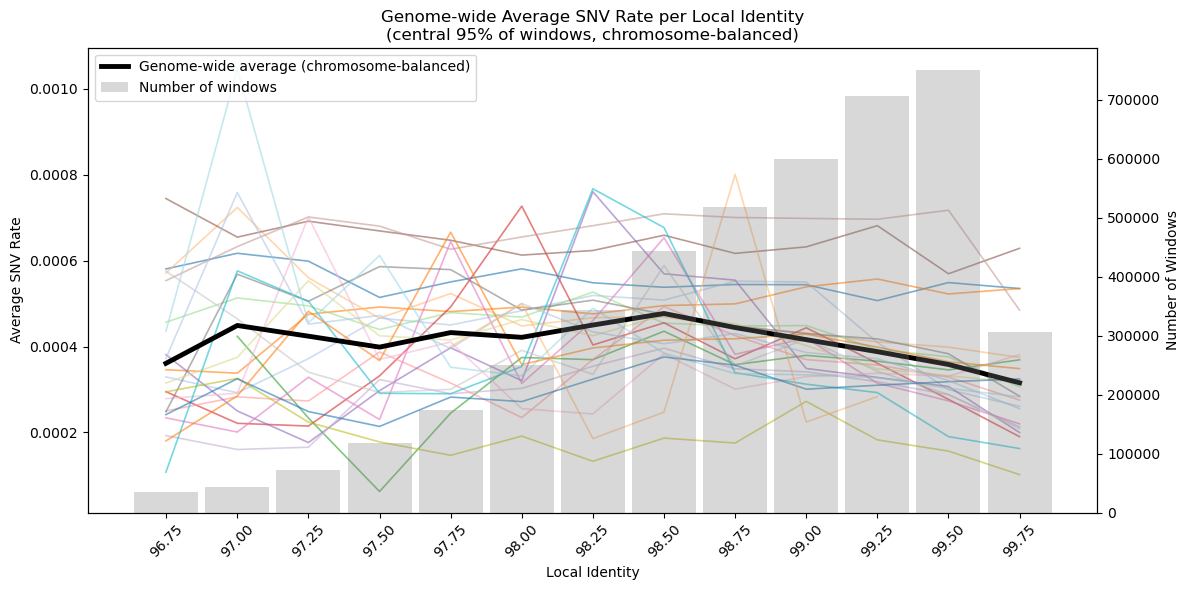

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Parameters
# ----------------------------
bin_size = 0.25

# ----------------------------
# Determine genome-wide 95% identity range
# ----------------------------
low_q, high_q = np.nanpercentile(
    all_snvs_df['local_identity'].values,
    [2.5, 97.5]
)

lower_bound = np.floor(low_q / bin_size) * bin_size
upper_bound = np.ceil(high_q / bin_size) * bin_size

bins = np.arange(lower_bound, upper_bound + bin_size, bin_size)
bin_width = bin_size

# ----------------------------
# Assign identity bins
# ----------------------------
all_snvs_df['identity_bin'] = pd.cut(
    all_snvs_df['local_identity'],
    bins=bins,
    include_lowest=True
)

# Drop windows outside the 95% range
all_snvs_df_95 = all_snvs_df.dropna(subset=['identity_bin'])

# ----------------------------
# Compute per-chromosome statistics
# ----------------------------
chrom_bin_stats = (
    all_snvs_df_95
    .groupby(['chr', 'identity_bin'])
    .agg(
        SNV_rate_chr_avg=('SNV_rate_aln', 'mean'),
        window_count_chr=('SNV_rate_aln', 'count')
    )
    .reset_index()
)

# Convert Interval → numeric positions (FORCE float)
chrom_bin_stats['bin_left'] = (
    chrom_bin_stats['identity_bin']
    .apply(lambda x: x.left)
    .astype(float)
)
chrom_bin_stats['bin_center'] = chrom_bin_stats['bin_left'] + bin_width / 2

# ----------------------------
# Compute genome-wide average (chromosome-balanced)
# ----------------------------
genome_stats = (
    chrom_bin_stats
    .groupby('identity_bin')
    .agg(
        SNV_rate_avg=('SNV_rate_chr_avg', 'mean'),  # equal-weight chrom mean
        n_chroms=('SNV_rate_chr_avg', 'count'),
        window_count=('window_count_chr', 'sum')    # total windows (bars)
    )
    .reset_index()
)

genome_stats['bin_left'] = (
    genome_stats['identity_bin']
    .apply(lambda x: x.left)
    .astype(float)
)
genome_stats['bin_center'] = genome_stats['bin_left'] + bin_width / 2

# ----------------------------
# Chromosome colors
# ----------------------------
chroms = sorted(chrom_bin_stats['chr'].unique())
cmap = plt.get_cmap('tab20')
chrom_colors = {chrom: cmap(i % cmap.N) for i, chrom in enumerate(chroms)}

# ----------------------------
# Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(12, 6))

# Per-chromosome lines (background)
for chrom, df_chrom in chrom_bin_stats.groupby('chr'):
    ax.plot(
        df_chrom['bin_center'],
        df_chrom['SNV_rate_chr_avg'],
        color=chrom_colors[chrom],
        linewidth=1.2,
        alpha=0.6,
        zorder=1
    )

# Genome-wide average line
ax.plot(
    genome_stats['bin_center'],
    genome_stats['SNV_rate_avg'],
    color='black',
    linewidth=3.5,
    label='Genome-wide average (chromosome-balanced)',
    zorder=3
)

ax.set_xlabel('Local Identity')
ax.set_ylabel('Average SNV Rate')
ax.grid(False)

# Secondary y-axis: number of windows
ax2 = ax.twinx()
ax2.bar(
    genome_stats['bin_center'],
    genome_stats['window_count'],
    width=0.9 * bin_width,
    align='center',
    alpha=0.3,
    color='gray',
    label='Number of windows',
    zorder=0
)

ax2.set_ylabel('Number of Windows')
ax2.grid(False)
ax2.ticklabel_format(axis='y', style='plain')
ax2.get_yaxis().get_offset_text().set_visible(False)

# X-axis ticks
ax.set_xticks(genome_stats['bin_center'])
ax.set_xticklabels(
    [f"{b:.2f}" for b in genome_stats['bin_left']],
    rotation=45
)

# Title
ax.set_title(
    'Genome-wide Average SNV Rate per Local Identity\n'
    '(central 95% of windows, chromosome-balanced)'
)

# Combined legend
lines, labels1 = ax.get_legend_handles_labels()
bars, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + bars, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()



### Short indels 

In [11]:
base_path = Path("/private/groups/patenlab/mira/centrolign/analysis/CDR_variant_regression/short_indels_triangles_aln_bases/")

# BED column names as given
columns = [
    "contig",
    "start",
    "end",
    "local_identity",
    "CDR_dist",
    "par_count",
    "par_rate",
    "trap_count",
    "trap_rate",
    "tri_count",
    "tri_rate",
    "aligned_bases"
]

dfs = []

for chr_dir in base_path.glob("chr*"):
    if not chr_dir.is_dir():
        continue

    chr_name = chr_dir.name

    for bed_file in chr_dir.glob("*.bed"):
        # Extract sample names
        name_part = bed_file.name.split(".aligned_bases.bed")[0]
        sample1, sample2 = name_part.split("_", 1)
        sample_pair = "_".join(sorted([sample1, sample2]))

        # Skip pairs not in allowed set
        if sample_pair not in allowed_pairs:
            continue

        df = pd.read_csv(
            bed_file,
            sep="\t",
            header=None,
            names=columns,
        )

        df["chr"] = chr_name
        df["sample1"] = sample1
        df["sample2"] = sample2
        df["sample_pair"] = sample_pair

        dfs.append(df)

# Combine only the filtered data
all_short_indels_df = pd.concat(dfs, ignore_index=True)

In [53]:
all_short_indels_df.head()

contig     start       end  local_identity  CDR_dist  \
0  HG00738#1#CM086650.1  50756450  50761449           97.59   1103517   
1  HG00738#1#CM086650.1  50761450  50766449           96.86   1098517   
2  HG00738#1#CM086650.1  50766450  50771449           96.66   1093517   
3  HG00738#1#CM086650.1  50771450  50776449           96.49   1088517   
4  HG00738#1#CM086650.1  50776450  50781449           97.00   1083517   

   par_count  par_rate  trap_count  trap_rate  tri_count  tri_rate  \
0          0       0.0           0        0.0          0       0.0   
1          0       0.0           0        0.0          0       0.0   
2          0       0.0           0        0.0          0       0.0   
3          0       0.0           0        0.0          0       0.0   
4          0       0.0           0        0.0          0       0.0   

   aligned_bases    chr    sample1    sample2          sample_pair  \
0           4999  chr11  HG00344.2  HG00738.1  HG00344.2_HG00738.1   
1           4999  chr11  HG00344.2  HG00738.1  HG00344.2_HG00738.1   
2           4999  chr11  HG00344.2  HG00738.1  HG00344.2_HG00738.1   
3           4999  chr11  HG00344.2  HG00738.1  HG00344.2_HG00738.1   
4           4999  chr11  HG00344.2  HG00738.1  HG00344.2_HG00738.1   

   tri_rate_per_aln  window_size  aligned_fraction  identity_bin  
0               0.0         4999               1.0  (97.5, 98.0]  
1               0.0         4999               1.0  (96.5, 97.0]  
2               0.0         4999               1.0  (96.5, 97.0]  
3               0.0         4999               1.0  (96.0, 96.5]  
4               0.0         4999               1.0  (96.5, 97.0]

In [56]:
all_short_indels_df["tri_trap_rate_per_aln"]=(all_short_indels_df["tri_count"] + all_short_indels_df["trap_count"])/all_short_indels_df["aligned_bases"]

# ----------------------------
# Filter windows with <20% aligned bases
# ----------------------------
all_short_indels_df["window_size"] = all_short_indels_df["end"] - all_short_indels_df["start"]
all_short_indels_df["aligned_fraction"] = all_short_indels_df["aligned_bases"] / all_short_indels_df["window_size"]

all_short_indels_df = all_short_indels_df[all_short_indels_df["aligned_fraction"] >= 0.2].copy()

#### Short indels - genome wide, 95%

/data/tmp/ipykernel_2801315/4115709297.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['chr', 'identity_bin'])
/data/tmp/ipykernel_2801315/4115709297.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('identity_bin')


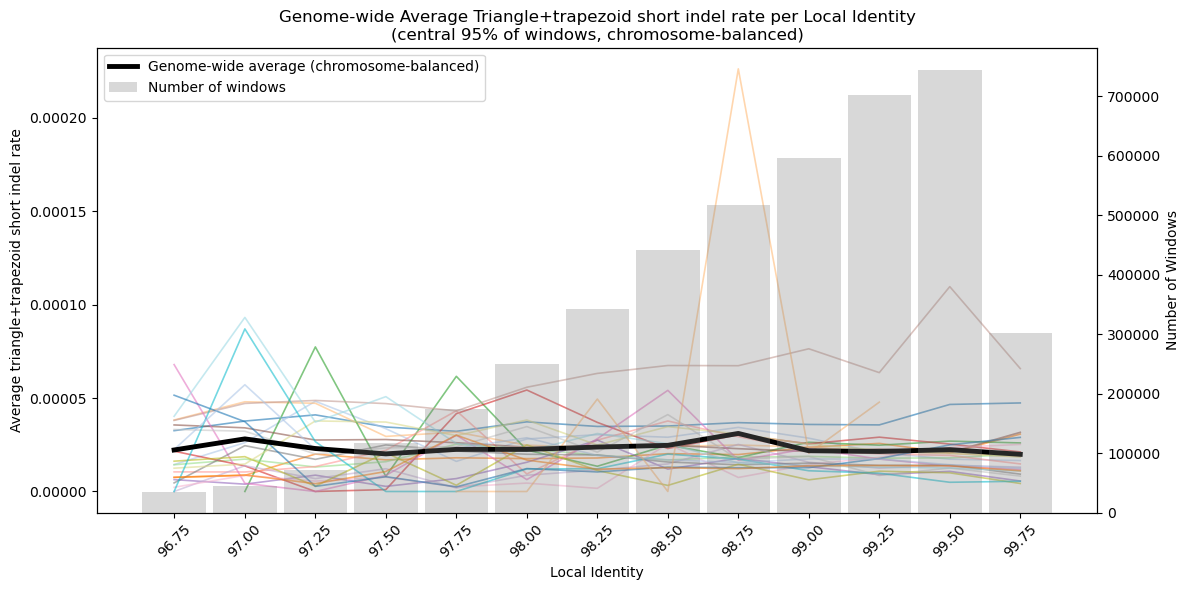

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Parameters
# ----------------------------
bin_size = 0.25

# ----------------------------
# Determine genome-wide 95% identity range
# ----------------------------
low_q, high_q = np.nanpercentile(
    all_short_indels_df['local_identity'].values,
    [2.5, 97.5]
)

lower_bound = np.floor(low_q / bin_size) * bin_size
upper_bound = np.ceil(high_q / bin_size) * bin_size

bins = np.arange(lower_bound, upper_bound + bin_size, bin_size)
bin_width = bin_size

# ----------------------------
# Assign identity bins
# ----------------------------
all_short_indels_df['identity_bin'] = pd.cut(
    all_short_indels_df['local_identity'],
    bins=bins,
    include_lowest=True
)

# Drop windows outside the 95% range
all_short_indels_df_95 = all_short_indels_df.dropna(subset=['identity_bin'])

# ----------------------------
# Compute per-chromosome statistics
# ----------------------------
chrom_bin_stats = (
    all_short_indels_df_95
    .groupby(['chr', 'identity_bin'])
    .agg(
        tri_trap_rate_chr_avg=('tri_trap_rate_per_aln', 'mean'),
        window_count_chr=('tri_trap_rate_per_aln', 'count')
    )
    .reset_index()
)

# Convert Interval → numeric positions (FORCE float)
chrom_bin_stats['bin_left'] = (
    chrom_bin_stats['identity_bin']
    .apply(lambda x: x.left)
    .astype(float)
)
chrom_bin_stats['bin_center'] = chrom_bin_stats['bin_left'] + bin_width / 2

# ----------------------------
# Compute genome-wide average (chromosome-balanced)
# ----------------------------
genome_stats = (
    chrom_bin_stats
    .groupby('identity_bin')
    .agg(
        tri_trap_rate_chr_avg=('tri_trap_rate_chr_avg', 'mean'),  # equal-weight chrom mean
        n_chroms=('tri_trap_rate_chr_avg', 'count'),
        window_count=('window_count_chr', 'sum')    # total windows (bars)
    )
    .reset_index()
)

genome_stats['bin_left'] = (
    genome_stats['identity_bin']
    .apply(lambda x: x.left)
    .astype(float)
)
genome_stats['bin_center'] = genome_stats['bin_left'] + bin_width / 2

# ----------------------------
# Chromosome colors
# ----------------------------
chroms = sorted(chrom_bin_stats['chr'].unique())
cmap = plt.get_cmap('tab20')
chrom_colors = {chrom: cmap(i % cmap.N) for i, chrom in enumerate(chroms)}

# ----------------------------
# Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(12, 6))

# Per-chromosome lines (background)
for chrom, df_chrom in chrom_bin_stats.groupby('chr'):
    ax.plot(
        df_chrom['bin_center'],
        df_chrom['tri_trap_rate_chr_avg'],
        color=chrom_colors[chrom],
        linewidth=1.2,
        alpha=0.6,
        zorder=1
    )

# Genome-wide average line
ax.plot(
    genome_stats['bin_center'],
    genome_stats['tri_trap_rate_chr_avg'],
    color='black',
    linewidth=3.5,
    label='Genome-wide average (chromosome-balanced)',
    zorder=3
)

ax.set_xlabel('Local Identity')
ax.set_ylabel('Average triangle+trapezoid short indel rate')
ax.grid(False)

# Secondary y-axis: number of windows
ax2 = ax.twinx()
ax2.bar(
    genome_stats['bin_center'],
    genome_stats['window_count'],
    width=0.9 * bin_width,
    align='center',
    alpha=0.3,
    color='gray',
    label='Number of windows',
    zorder=0
)

ax2.set_ylabel('Number of Windows')
ax2.grid(False)
ax2.ticklabel_format(axis='y', style='plain')
ax2.get_yaxis().get_offset_text().set_visible(False)

# X-axis ticks
ax.set_xticks(genome_stats['bin_center'])
ax.set_xticklabels(
    [f"{b:.2f}" for b in genome_stats['bin_left']],
    rotation=45
)

# Title
ax.set_title(
    'Genome-wide Average Triangle+trapezoid short indel rate per Local Identity\n'
    '(central 95% of windows, chromosome-balanced)'
)

# Combined legend
lines, labels1 = ax.get_legend_handles_labels()
bars, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + bars, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()



#### Short indels - per chrom 95%

/data/tmp/ipykernel_2801315/2172733108.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['chr', 'identity_bin'])


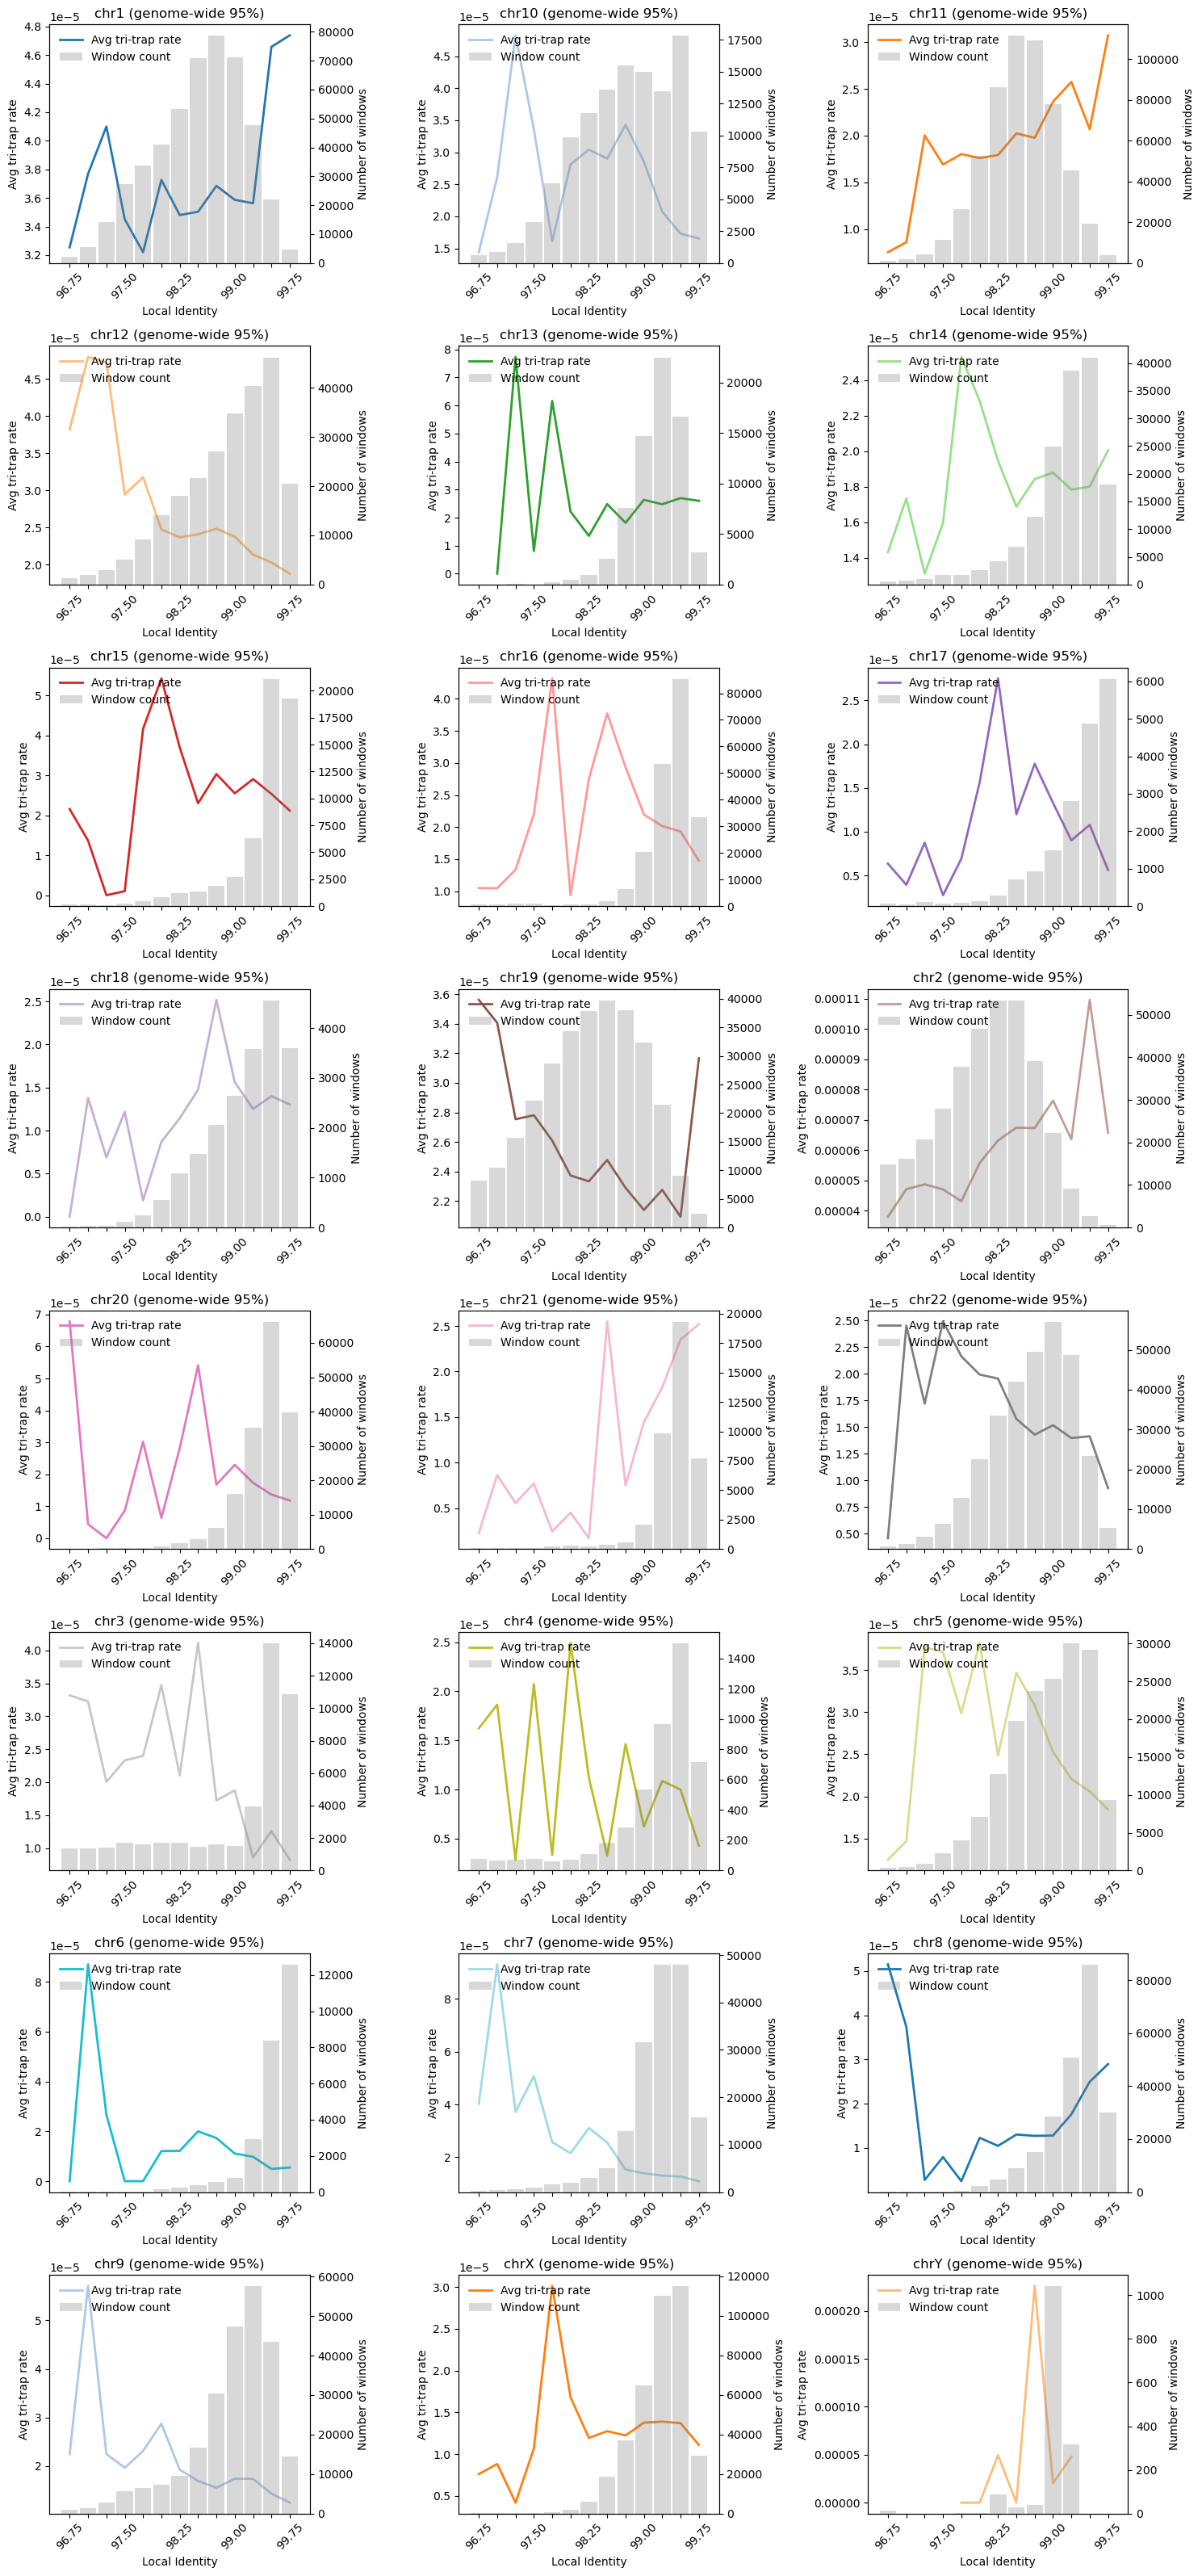

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Parameters
# ----------------------------
bin_size = 0.25
n_cols = 3
label_every = 3  # show every Nth x tick label

# ----------------------------
# Compute genome-wide 95% identity range
# ----------------------------
low_q, high_q = np.nanpercentile(
    all_short_indels_df['local_identity'].values,
    [2.5, 97.5]
)

lower_bound = np.floor(low_q / bin_size) * bin_size
upper_bound = np.ceil(high_q / bin_size) * bin_size

bins = np.arange(lower_bound, upper_bound + bin_size, bin_size)
bin_width = bin_size
bin_left_edges = bins[:-1]
bin_centers = bin_left_edges + bin_width / 2

# ----------------------------
# Assign bins genome-wide
# ----------------------------
all_short_indels_df['identity_bin'] = pd.cut(
    all_short_indels_df['local_identity'],
    bins=bins,
    include_lowest=True
)

# Keep only windows inside genome-wide 95%
all_short_indels_df_95 = all_short_indels_df.dropna(subset=['identity_bin'])

# ----------------------------
# Per-chromosome aggregation (shared bins)
# ----------------------------
chrom_avg = (
    all_short_indels_df_95
    .groupby(['chr', 'identity_bin'])
    .agg(
        tri_trap_rate_avg=('tri_trap_rate_per_aln', 'mean'),
        window_count=('tri_trap_rate_per_aln', 'count')
    )
    .reset_index()
)

# Convert Interval → numeric (force float)
chrom_avg['bin_left'] = (
    chrom_avg['identity_bin']
    .apply(lambda x: x.left)
    .astype(float)
)
chrom_avg['bin_center'] = chrom_avg['bin_left'] + bin_width / 2

# ----------------------------
# Faceted plotting setup
# ----------------------------
chromosomes = chrom_avg['chr'].unique()
n_chroms = len(chromosomes)
n_rows = int(np.ceil(n_chroms / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 5, n_rows * 4),
    sharey=False
)
axes = axes.flatten()

colors = plt.cm.tab20.colors

# ----------------------------
# Plot per chromosome
# ----------------------------
for i, chrom in enumerate(chromosomes):
    ax = axes[i]
    chrom_data = chrom_avg[chrom_avg['chr'] == chrom]

    # Line: average SNV rate
    l1, = ax.plot(
        chrom_data['bin_center'],
        chrom_data['tri_trap_rate_avg'],
        color=colors[i % len(colors)],
        linewidth=2
    )

    # Bars: number of windows
    ax2 = ax.twinx()
    l2 = ax2.bar(
        chrom_data['bin_center'],
        chrom_data['window_count'],
        width=0.9 * bin_width,
        align='center',
        alpha=0.3,
        color='gray'
    )

    # X ticks (shared across chroms)
    xtick_labels = [
        f"{bin_left_edges[j]:.2f}" if j % label_every == 0 else ''
        for j in range(len(bin_left_edges))
    ]

    ax.set_xticks(bin_centers)
    ax.set_xticklabels(xtick_labels, rotation=45)

    # Labels
    ax.set_xlabel('Local Identity')
    ax.set_ylabel('Avg tri-trap rate')
    ax2.set_ylabel('Number of windows')

    ax.set_title(f'{chrom} (genome-wide 95%)')

    ax.grid(False)
    ax2.grid(False)

    ax.legend(
        handles=[l1, l2],
        labels=['Avg tri-trap rate', 'Window count'],
        loc='upper left',
        frameon=False
    )

# ----------------------------
# Remove unused panels
# ----------------------------
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### Short indels - 95% of each chrom

/data/tmp/ipykernel_2801315/3263480837.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chrom_avg = all_short_indels_df.groupby(['chr', 'identity_bin']).agg(


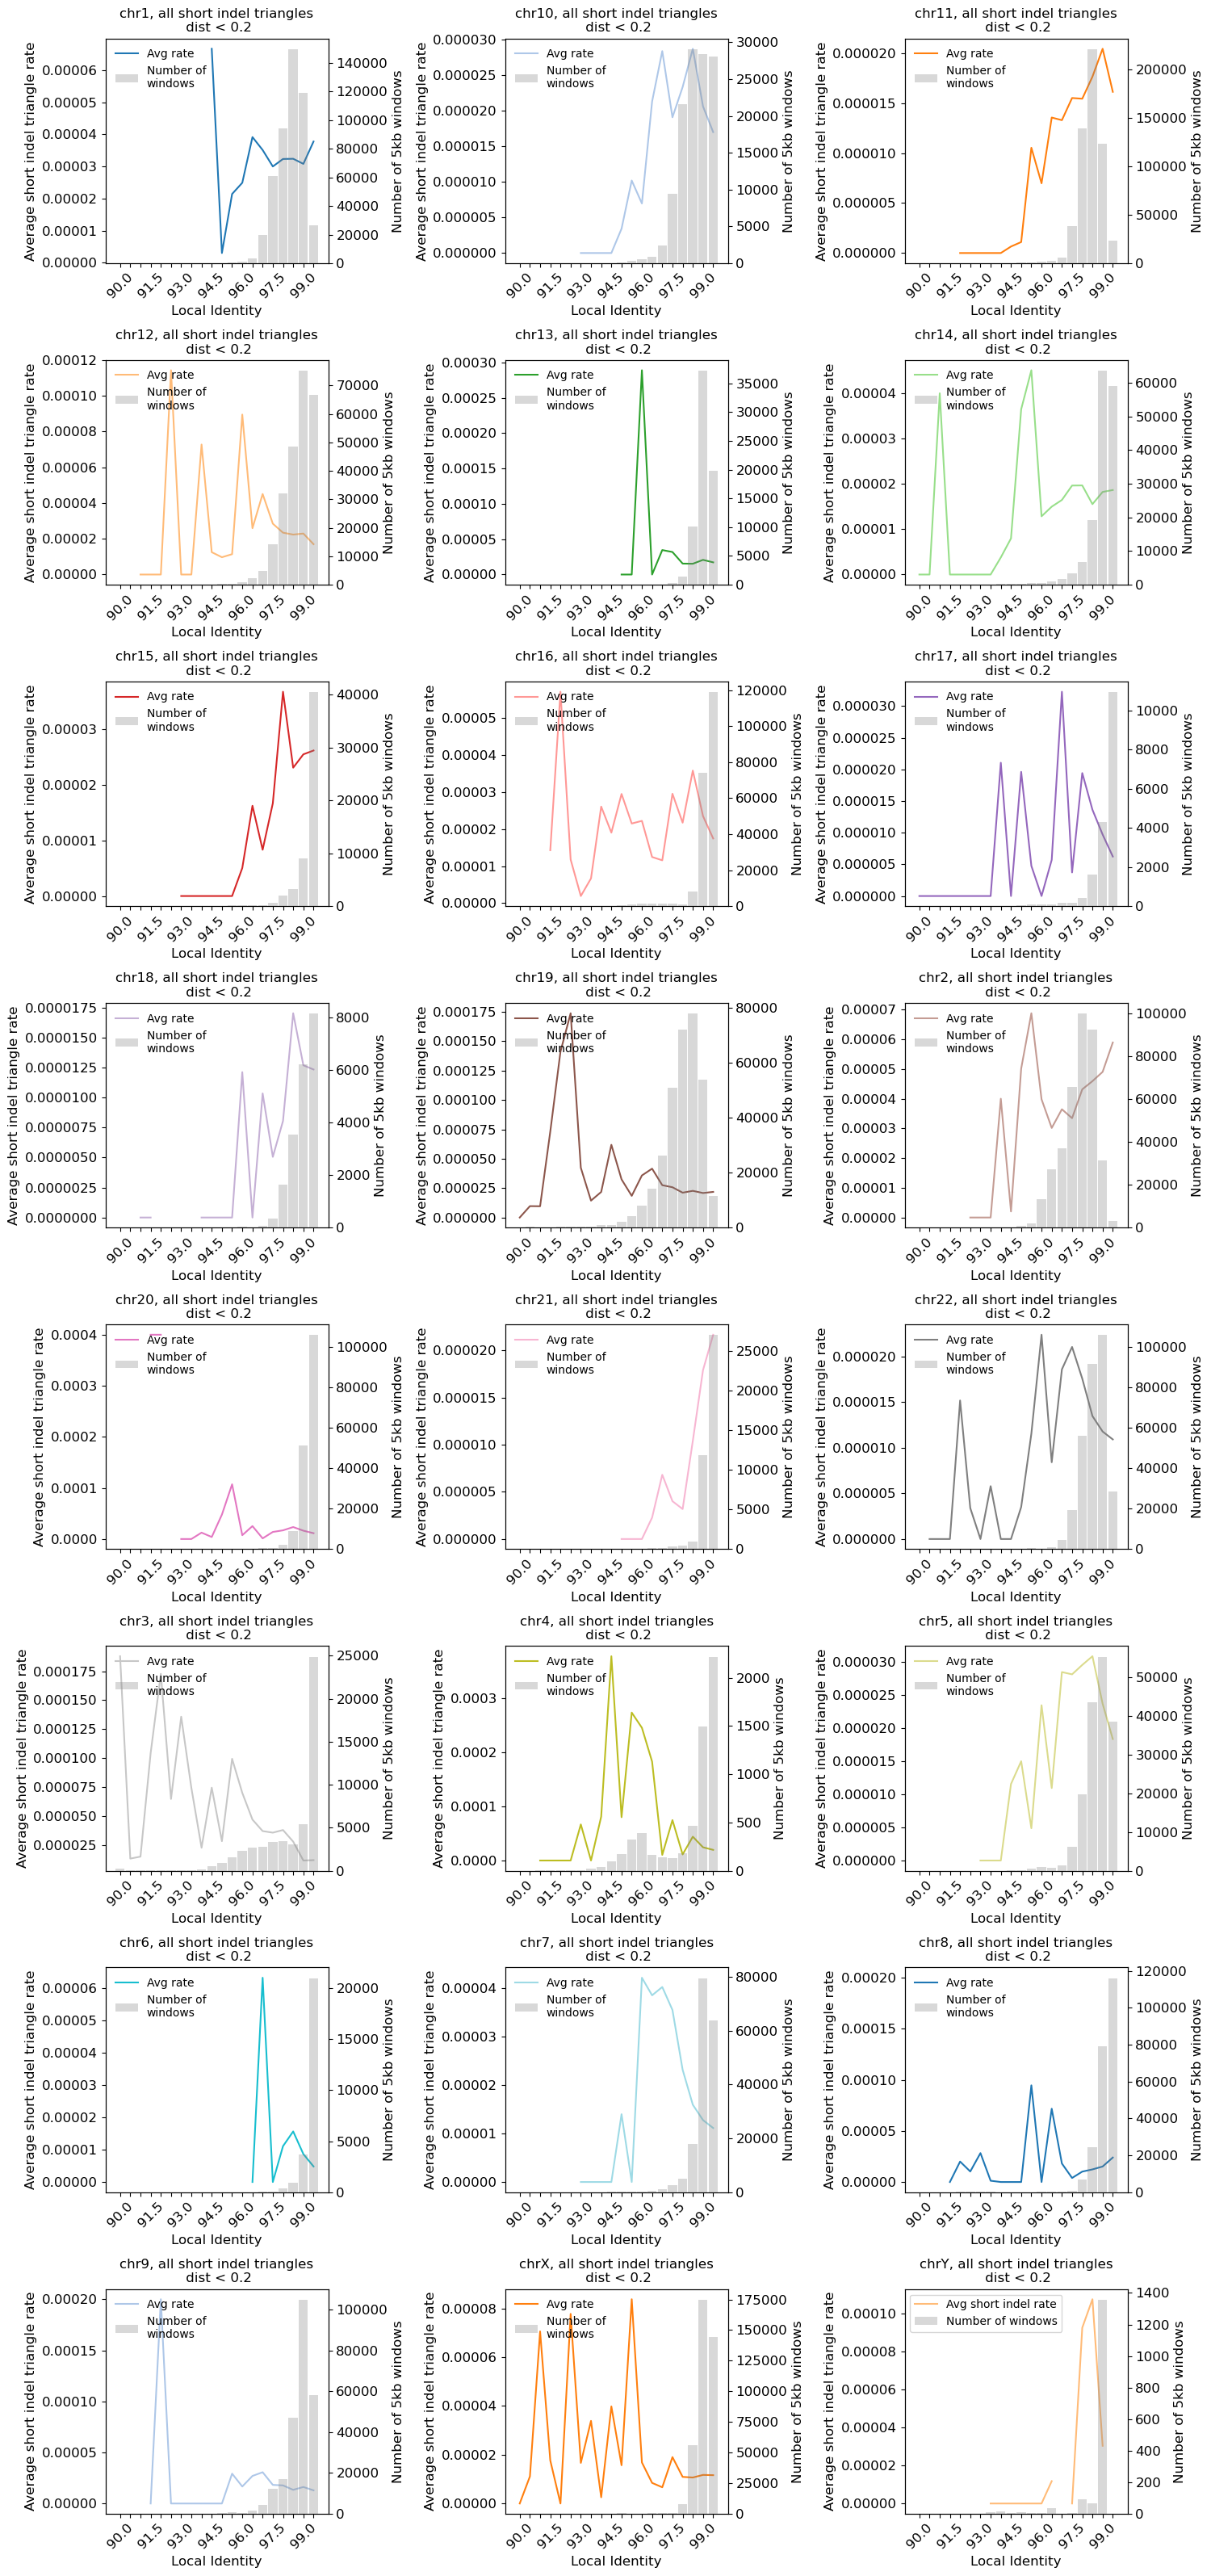

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Create bins from 85 to 100 in steps of 0.5
bins = np.arange(90, 100.5, 0.5)  # bin edges
bin_left_edges = bins[:-1]  # left edges for plotting and labels

# Add 'identity_bin' column
all_short_indels_df['identity_bin'] = pd.cut(all_short_indels_df['local_identity'], bins=bins, include_lowest=True)

# Compute average SNV rate per chromosome per bin
chrom_avg = all_short_indels_df.groupby(['chr', 'identity_bin']).agg(
    short_indel_rate_avg=('tri_rate', 'mean'),
    window_count=('tri_rate', 'count')  # number of windows in the bin
).reset_index()

# Convert 'identity_bin' (intervals) to numeric x-values: use left edge
chrom_avg['bin_left'] = chrom_avg['identity_bin'].apply(lambda x: x.left)

# List of chromosomes
chromosomes = chrom_avg['chr'].unique()
n_chroms = len(chromosomes)

# Determine grid size for subplots
n_cols = 3
n_rows = int(np.ceil(n_chroms / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4), sharey=False)
axes = axes.flatten()

# Colormap for chromosome lines
colors = plt.cm.tab20.colors  # up to 20 distinct colors
N = 3  # Show every Nth x-axis label

for i, chrom in enumerate(chromosomes):
    ax = axes[i]
    chrom_data = chrom_avg[chrom_avg['chr'] == chrom]
    
    l1, = ax.plot(
        chrom_data['bin_left'],
        chrom_data['short_indel_rate_avg'],
        color=colors[i % len(colors)],
        label='Avg short indel rate'
    )
    
    ax2 = ax.twinx()
    l2 = ax2.bar(
        chrom_data['bin_left'],
        chrom_data['window_count'],
        width=0.45,
        alpha=0.3,
        color='gray',
        label='Number of windows'
    )
    
    ax.set_ylabel('Average short indel triangle rate',fontsize=12)
    ax2.set_ylabel('Number of 5kb windows',fontsize=12)

    # Disable scientific notation on left y-axis
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax.ticklabel_format(axis='y', style='plain')
    ax.yaxis.get_offset_text().set_visible(False)

    # Disable scientific notation on right y-axis
    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax2.ticklabel_format(axis='y', style='plain')
    ax2.yaxis.get_offset_text().set_visible(False)

    ax.grid(False)
    ax2.grid(False)

    # X ticks
    tick_labels = [
        str(bin_left_edges[j]) if j % N == 0 else ''
        for j in range(len(bin_left_edges))
    ]
    ax.set_xticks(bin_left_edges)
    ax.set_xticklabels(tick_labels, rotation=45,fontsize=12)
    ax.tick_params(axis='both', labelsize=12)
    ax2.tick_params(axis='y', labelsize=12)

    ax.set_xlabel("Local Identity",fontsize=12)
    ax.set_title(f'{chrom}, all short indel triangles\n dist < 0.2',fontsize=12)

    ax.legend(
        handles=[l1, l2],
        labels=['Avg rate', 'Number of\nwindows'],
        loc='upper left',
        frameon=False
    )


# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Legend (combined)
lines, labels1 = ax.get_legend_handles_labels()
bars, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + bars, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()



### Short indels / aligned bases instead of windowsize

/data/tmp/ipykernel_1918063/2182691092.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chrom_avg = all_short_indels_df.groupby(['chr', 'identity_bin']).agg(


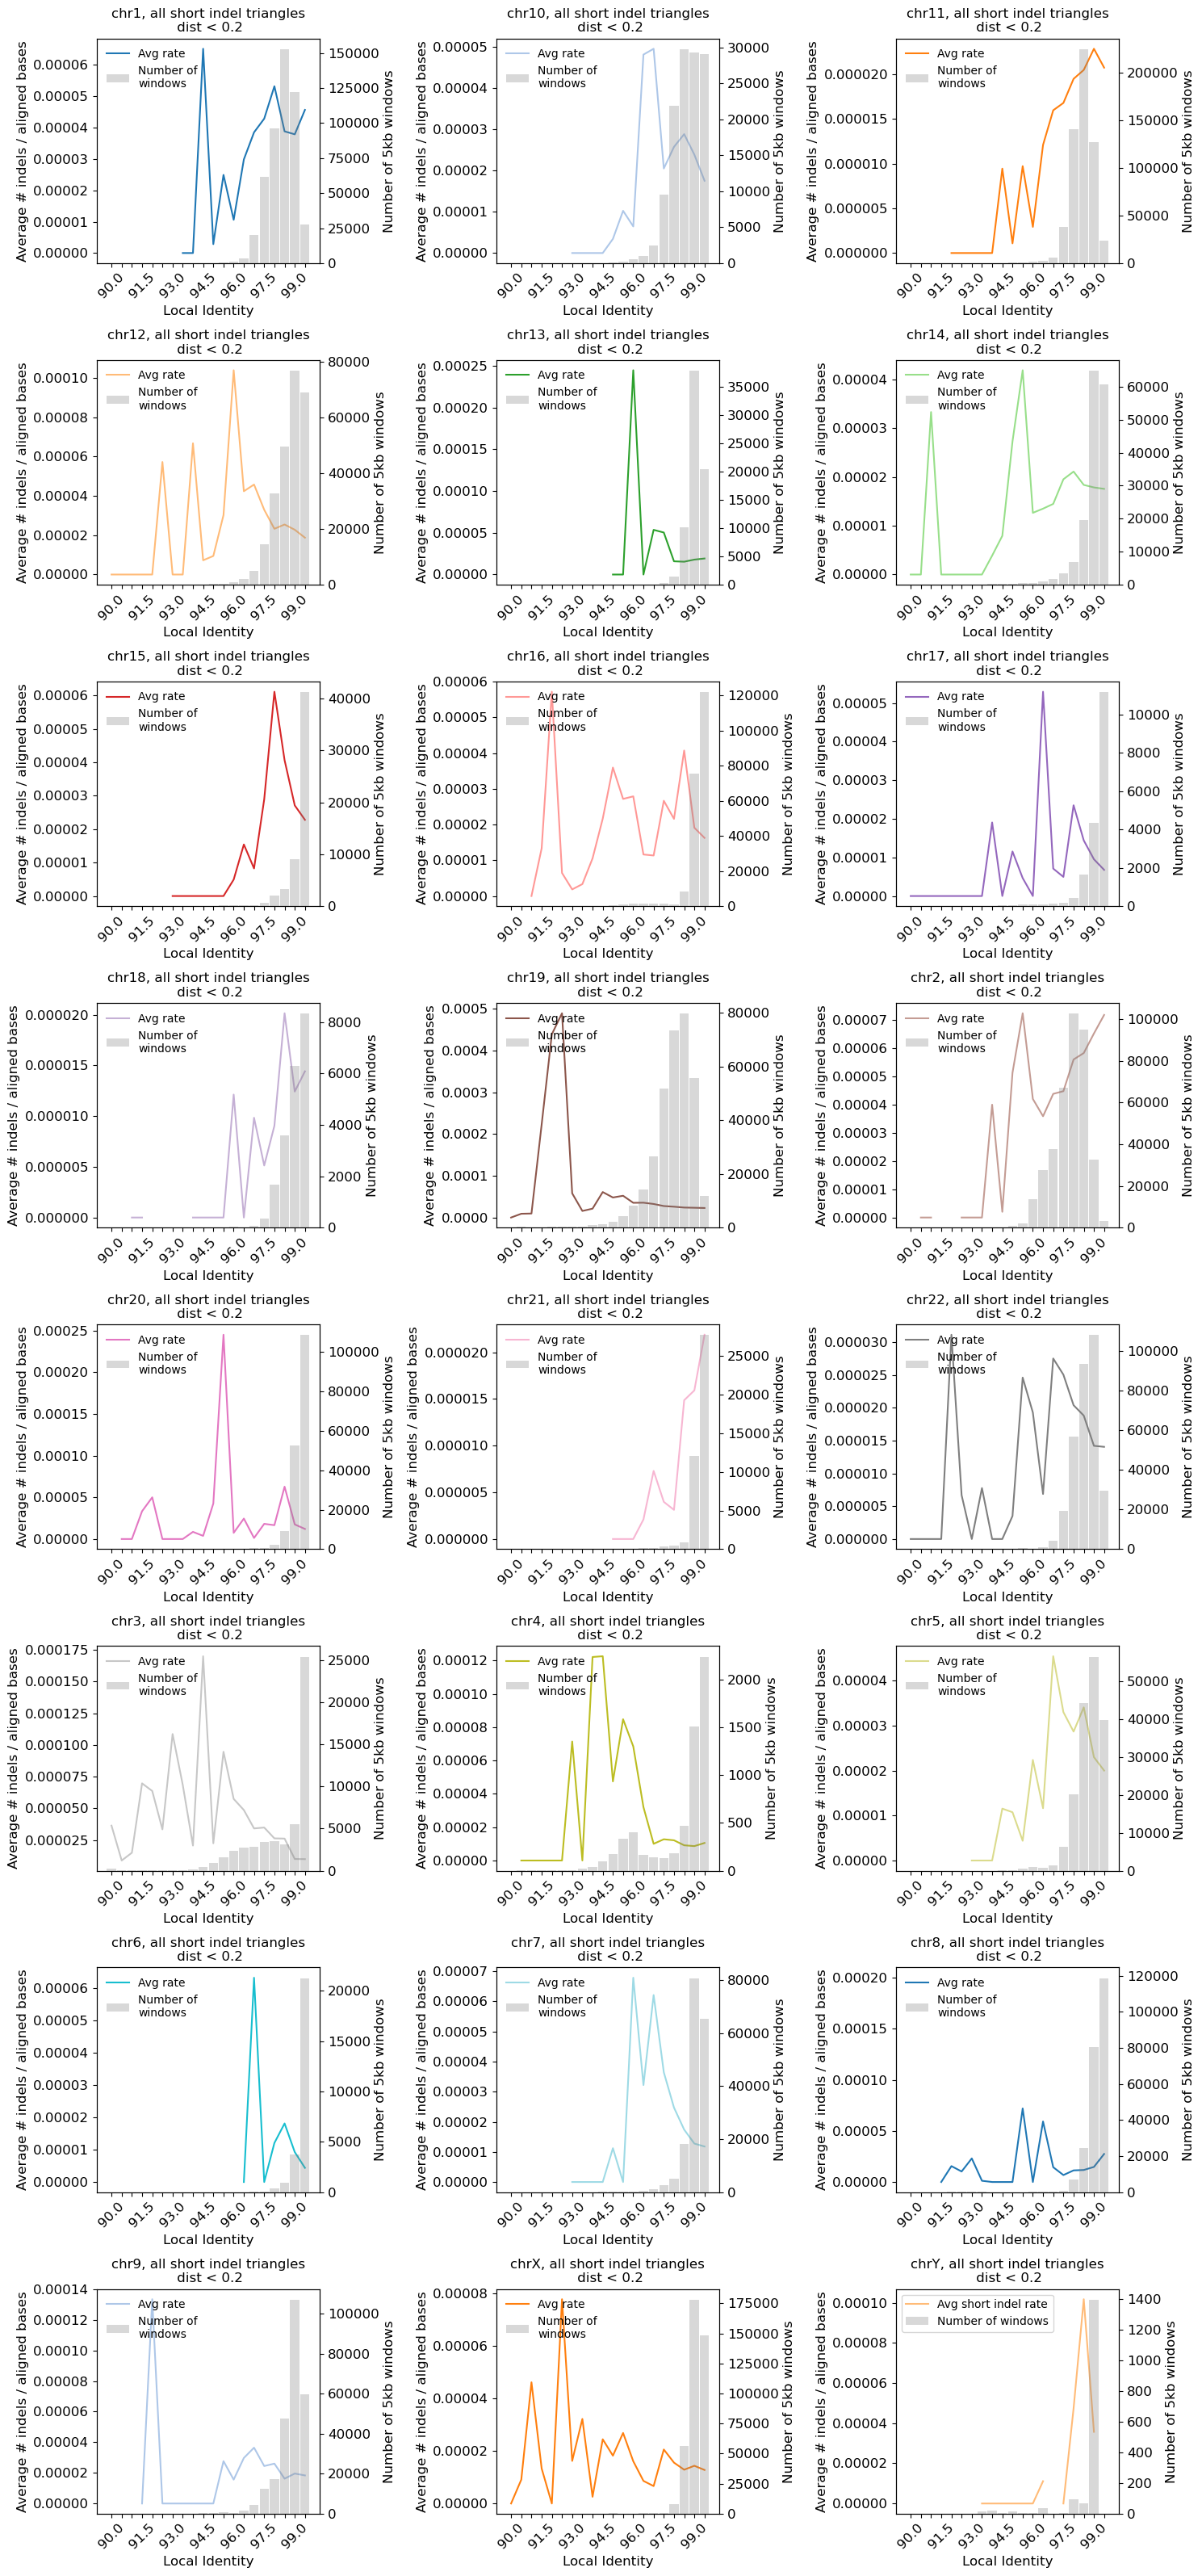

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Create bins from 85 to 100 in steps of 0.5
bins = np.arange(90, 100.5, 0.5)  # bin edges
bin_left_edges = bins[:-1]  # left edges for plotting and labels

# Add 'identity_bin' column
all_short_indels_df['identity_bin'] = pd.cut(all_short_indels_df['local_identity'], bins=bins, include_lowest=True)

# Compute average SNV rate per chromosome per bin
chrom_avg = all_short_indels_df.groupby(['chr', 'identity_bin']).agg(
    short_indel_rate_avg=('tri_rate_per_aln', 'mean'),
    window_count=('tri_rate_per_aln', 'count')  # number of windows in the bin
).reset_index()

# Convert 'identity_bin' (intervals) to numeric x-values: use left edge
chrom_avg['bin_left'] = chrom_avg['identity_bin'].apply(lambda x: x.left)

# List of chromosomes
chromosomes = chrom_avg['chr'].unique()
n_chroms = len(chromosomes)

# Determine grid size for subplots
n_cols = 3
n_rows = int(np.ceil(n_chroms / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4), sharey=False)
axes = axes.flatten()

# Colormap for chromosome lines
colors = plt.cm.tab20.colors  # up to 20 distinct colors
N = 3  # Show every Nth x-axis label

for i, chrom in enumerate(chromosomes):
    ax = axes[i]
    chrom_data = chrom_avg[chrom_avg['chr'] == chrom]
    
    l1, = ax.plot(
        chrom_data['bin_left'],
        chrom_data['short_indel_rate_avg'],
        color=colors[i % len(colors)],
        label='Avg short indel rate'
    )
    
    ax2 = ax.twinx()
    l2 = ax2.bar(
        chrom_data['bin_left'],
        chrom_data['window_count'],
        width=0.45,
        alpha=0.3,
        color='gray',
        label='Number of windows'
    )
    
    ax.set_ylabel('Average # indels / aligned bases',fontsize=12)
    ax2.set_ylabel('Number of 5kb windows',fontsize=12)

    # Disable scientific notation on left y-axis
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax.ticklabel_format(axis='y', style='plain')
    ax.yaxis.get_offset_text().set_visible(False)

    # Disable scientific notation on right y-axis
    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax2.ticklabel_format(axis='y', style='plain')
    ax2.yaxis.get_offset_text().set_visible(False)

    ax.grid(False)
    ax2.grid(False)

    # X ticks
    tick_labels = [
        str(bin_left_edges[j]) if j % N == 0 else ''
        for j in range(len(bin_left_edges))
    ]
    ax.set_xticks(bin_left_edges)
    ax.set_xticklabels(tick_labels, rotation=45,fontsize=12)
    ax.tick_params(axis='both', labelsize=12)
    ax2.tick_params(axis='y', labelsize=12)

    ax.set_xlabel("Local Identity",fontsize=12)
    ax.set_title(f'{chrom}, all short indel triangles\n dist < 0.2',fontsize=12)

    ax.legend(
        handles=[l1, l2],
        labels=['Avg rate', 'Number of\nwindows'],
        loc='upper left',
        frameon=False
    )


# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Legend (combined)
lines, labels1 = ax.get_legend_handles_labels()
bars, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + bars, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

### Plotting both short indels and SNV rate on the per chrom plots 

/data/tmp/ipykernel_2801315/3782587316.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['chr', 'identity_bin'])
/data/tmp/ipykernel_2801315/3782587316.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['chr', 'identity_bin'])


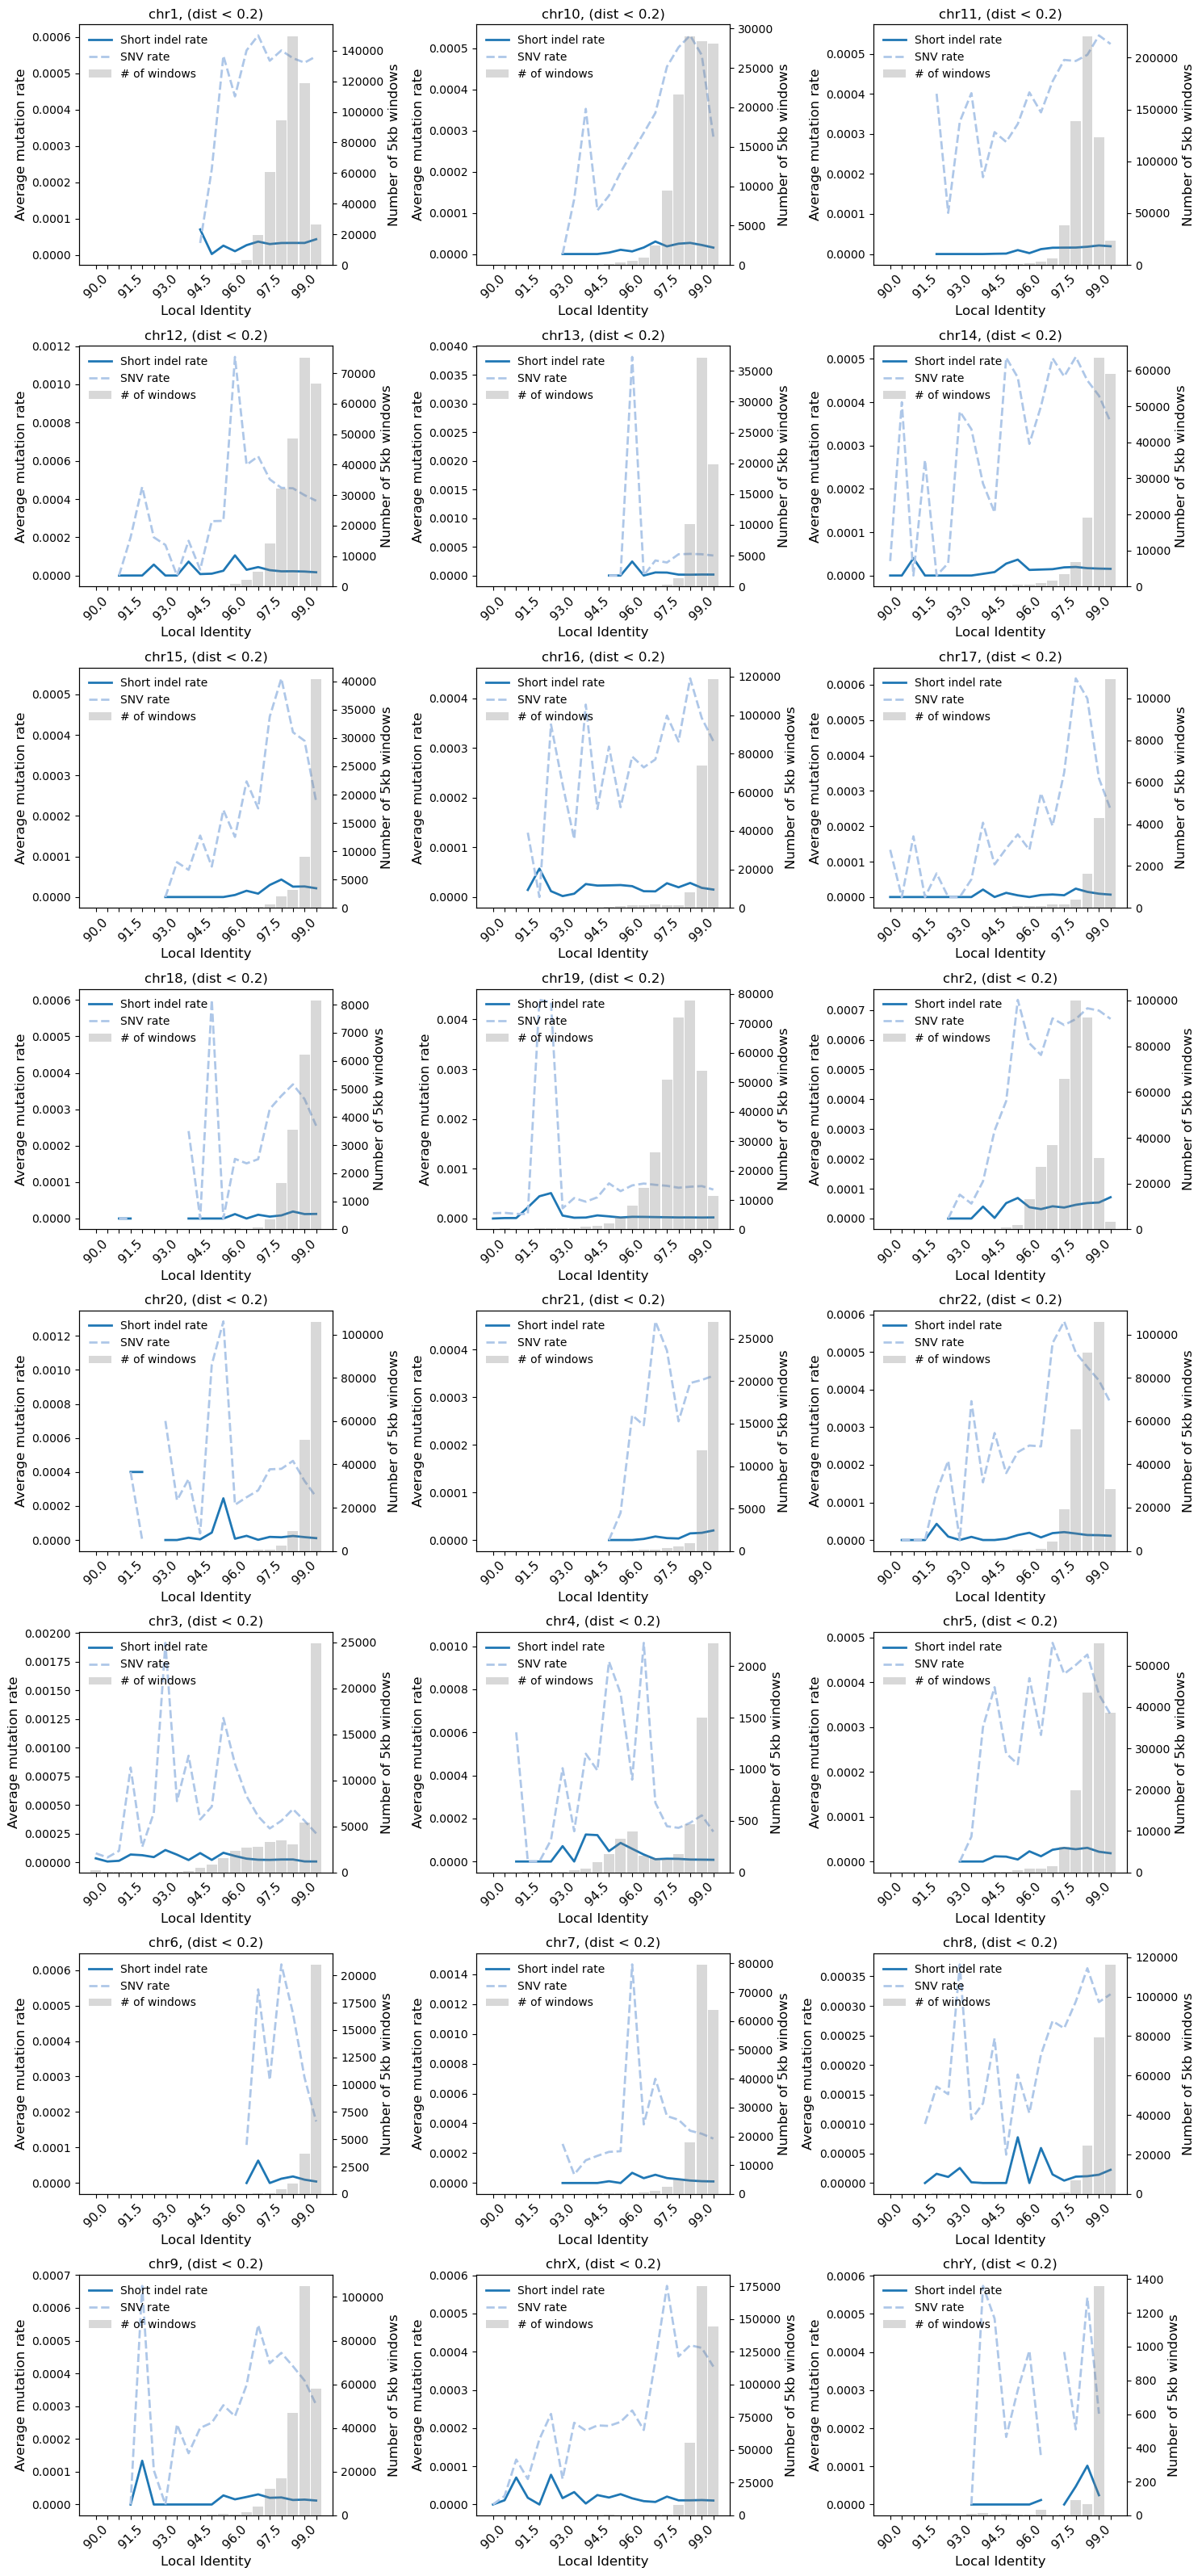

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# ----------------------------
# Binning
# ----------------------------
bins = np.arange(90, 100.5, 0.5)
bin_left_edges = bins[:-1]
N = 3  # show every Nth x tick

all_short_indels_df['identity_bin'] = pd.cut(
    all_short_indels_df['local_identity'], bins=bins, include_lowest=True
)
all_snvs_df['identity_bin'] = pd.cut(
    all_snvs_df['local_identity'], bins=bins, include_lowest=True
)

# ----------------------------
# Aggregate short indels
# ----------------------------
short_avg = (
    all_short_indels_df
    .groupby(['chr', 'identity_bin'])
    .agg(
        short_indel_rate_avg=('tri_rate_per_aln', 'mean'),
        window_count=('tri_rate_per_aln', 'count')
    )
    .reset_index()
)

# ----------------------------
# Aggregate SNVs
# ----------------------------
snv_avg = (
    all_snvs_df
    .groupby(['chr', 'identity_bin'])
    .agg(
        SNV_rate_avg=('SNV_rate_aln', 'mean')
    )
    .reset_index()
)

# ----------------------------
# Merge
# ----------------------------
chrom_avg = pd.merge(
    short_avg,
    snv_avg,
    on=['chr', 'identity_bin'],
    how='inner'
)

chrom_avg['bin_left'] = chrom_avg['identity_bin'].apply(lambda x: x.left)

# ----------------------------
# Plot setup
# ----------------------------
chromosomes = chrom_avg['chr'].unique()
n_chroms = len(chromosomes)

n_cols = 3
n_rows = int(np.ceil(n_chroms / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 5, n_rows * 4),
    sharey=False
)
axes = axes.flatten()

colors = plt.cm.tab20.colors

# ----------------------------
# Plot per chromosome
# ----------------------------
for i, chrom in enumerate(chromosomes):
    ax = axes[i]
    chrom_data = chrom_avg[chrom_avg['chr'] == chrom]

    # Short indel rate
    l1, = ax.plot(
        chrom_data['bin_left'],
        chrom_data['short_indel_rate_avg'],
        color=colors[0],
        linewidth=2,
        label='Short indel rate'
    )

    # SNV rate
    l2, = ax.plot(
        chrom_data['bin_left'],
        chrom_data['SNV_rate_avg'],
        color=colors[1],
        linestyle='--',
        linewidth=2,
        label='SNV rate'
    )

    # Window counts (right axis)
    ax2 = ax.twinx()
    b1 = ax2.bar(
        chrom_data['bin_left'],
        chrom_data['window_count'],
        width=0.45,
        alpha=0.3,
        color='gray',
        label='Number of windows'
    )

    # Labels
    ax.set_ylabel('Average mutation rate', fontsize=12)
    ax2.set_ylabel('Number of 5kb windows', fontsize=12)
    ax.set_xlabel('Local Identity', fontsize=12)

    # Formatting
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax.ticklabel_format(axis='y', style='plain')
    ax.yaxis.get_offset_text().set_visible(False)

    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax2.ticklabel_format(axis='y', style='plain')
    ax2.yaxis.get_offset_text().set_visible(False)

    tick_labels = [
        str(bin_left_edges[j]) if j % N == 0 else ''
        for j in range(len(bin_left_edges))
    ]
    ax.set_xticks(bin_left_edges)
    ax.set_xticklabels(tick_labels, rotation=45, fontsize=11)

    ax.set_title(
        f'{chrom}, (dist < 0.2)',
        fontsize=12
    )

    ax.legend(
        handles=[l1, l2, b1],
        labels=[
            'Short indel rate',
            'SNV rate',
            '# of windows'
        ],
        loc='upper left',
        frameon=False
    )

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### SVs - triangles & trapezoids only 

In [8]:
base_path = Path("/private/groups/patenlab/mira/centrolign/analysis/CDR_variant_regression/SVs_pairwise_all/")

# BED column names as given
columns = [
    "contig",
    "start",
    "end",
    "local_identity",
    "CDR_dist",
    "par_count",
    "par_rate",
    "trap_count",
    "trap_rate",
    "tri_count",
    "tri_rate"
]

dfs = []

for chr_dir in base_path.glob("chr*"):
    if not chr_dir.is_dir():
        continue

    chr_name = chr_dir.name

    for bed_file in chr_dir.glob("*.bed"):
        # Extract sample names
        name_part = bed_file.name.split(".all_SV_counts.bed")[0]
        sample1, sample2 = name_part.split("_", 1)
        sample_pair = "_".join(sorted([sample1, sample2]))

        # Skip pairs not in allowed set
        if sample_pair not in allowed_pairs:
            continue

        df = pd.read_csv(
            bed_file,
            sep="\t",
            header=None,
            names=columns,
        )

        df["chr"] = chr_name
        df["sample1"] = sample1
        df["sample2"] = sample2
        df["sample_pair"] = sample_pair

        dfs.append(df)

# Combine only the filtered data
all_SVs_df = pd.concat(dfs, ignore_index=True)

/data/tmp/ipykernel_1198596/3457111549.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_SVs_df = pd.concat(dfs, ignore_index=True)


In [6]:
all_SVs_df.head()

contig     start       end  local_identity CDR_dist  \
0  HG00741#2#JAHALX020000030.1  50986082  50991081           97.57  1503954   
1  HG00741#2#JAHALX020000030.1  50991082  50996081           96.74  1498954   
2  HG00741#2#JAHALX020000030.1  50996082  51001081           96.67  1493954   
3  HG00741#2#JAHALX020000030.1  51001082  51006081           96.50  1488954   
4  HG00741#2#JAHALX020000030.1  51006082  51011081           97.15  1483954   

  par_count  par_rate trap_count  trap_rate tri_count  tri_rate    chr  \
0         0       0.0          0        0.0         0  0.000000  chr11   
1         0       0.0          0        0.0         0  0.000000  chr11   
2         0       0.0          0        0.0         0  0.000000  chr11   
3         0       0.0          0        0.0         0  0.000000  chr11   
4         0       0.0          0        0.0         1  0.169634  chr11   

     sample1    sample2          sample_pair  
0  HG00741.2  HG00735.1  HG00735.1_HG00741.2  
1  HG00741.2  HG00735.1  HG00735.1_HG00741.2  
2  HG00741.2  HG00735.1  HG00735.1_HG00741.2  
3  HG00741.2  HG00735.1  HG00735.1_HG00741.2  
4  HG00741.2  HG00735.1  HG00735.1_HG00741.2

/data/tmp/ipykernel_1490520/319909664.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chrom_avg = all_SVs_df.groupby(['chr', 'identity_bin']).agg(


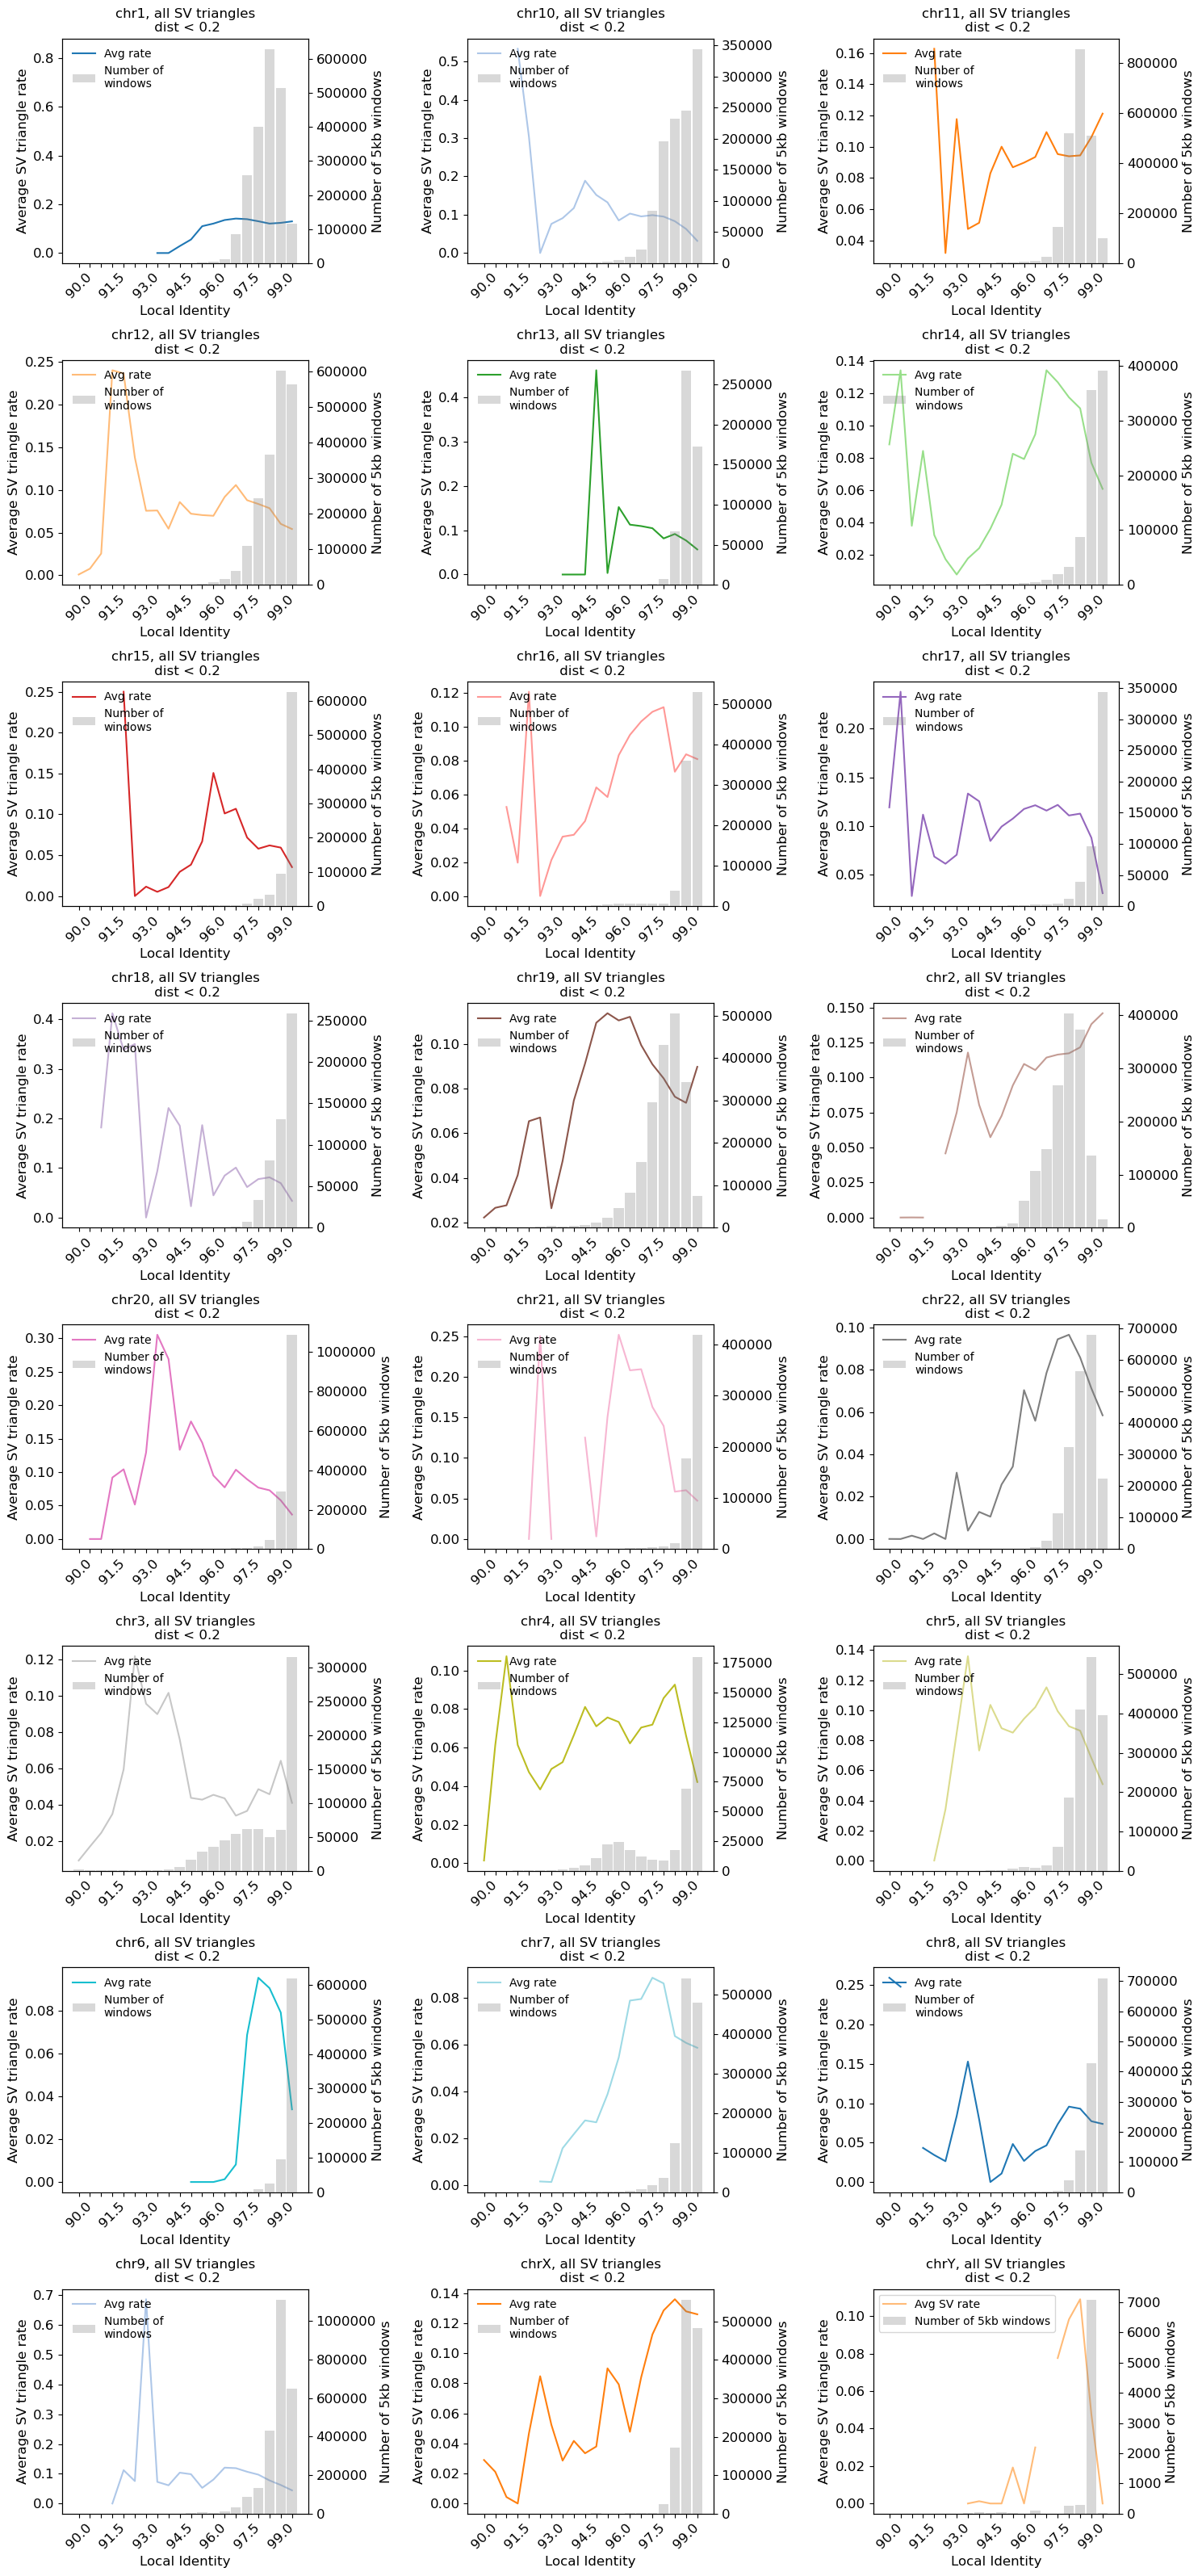

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Create bins from 85 to 100 in steps of 0.5
bins = np.arange(90, 100.5, 0.5)  # bin edges
bin_left_edges = bins[:-1]  # left edges for plotting and labels

# Add 'identity_bin' column
all_SVs_df['identity_bin'] = pd.cut(all_SVs_df['local_identity'], bins=bins, include_lowest=True)

# Compute average SNV rate per chromosome per bin
chrom_avg = all_SVs_df.groupby(['chr', 'identity_bin']).agg(
    SV_rate_avg=('tri_rate', 'mean'),
    window_count=('tri_rate', 'count')  # number of windows in the bin
).reset_index()

# Convert 'identity_bin' (intervals) to numeric x-values: use left edge
chrom_avg['bin_left'] = chrom_avg['identity_bin'].apply(lambda x: x.left)

# List of chromosomes
chromosomes = chrom_avg['chr'].unique()
n_chroms = len(chromosomes)

# Determine grid size for subplots
n_cols = 3
n_rows = int(np.ceil(n_chroms / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4), sharey=False)
axes = axes.flatten()

# Colormap for chromosome lines
colors = plt.cm.tab20.colors  # up to 20 distinct colors
N = 3  # Show every Nth x-axis label

for i, chrom in enumerate(chromosomes):
    ax = axes[i]
    chrom_data = chrom_avg[chrom_avg['chr'] == chrom]
    
    l1, = ax.plot(
        chrom_data['bin_left'],
        chrom_data['SV_rate_avg'],
        color=colors[i % len(colors)],
        label='Avg SV rate'
    )
    
    ax2 = ax.twinx()
    l2 = ax2.bar(
        chrom_data['bin_left'],
        chrom_data['window_count'],
        width=0.45,
        alpha=0.3,
        color='gray',
        label='Number of 5kb windows'
    )
    
    ax.set_ylabel('Average SV triangle rate',fontsize=12)
    ax2.set_ylabel('Number of 5kb windows',fontsize=12)

    # Disable scientific notation on left y-axis
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax.ticklabel_format(axis='y', style='plain')
    ax.yaxis.get_offset_text().set_visible(False)

    # Disable scientific notation on right y-axis
    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax2.ticklabel_format(axis='y', style='plain')
    ax2.yaxis.get_offset_text().set_visible(False)

    ax.grid(False)
    ax2.grid(False)

    # X ticks
    tick_labels = [
        str(bin_left_edges[j]) if j % N == 0 else ''
        for j in range(len(bin_left_edges))
    ]
    ax.set_xticks(bin_left_edges)
    ax.set_xticklabels(tick_labels, rotation=45,fontsize=12)
    ax.tick_params(axis='both', labelsize=12)
    ax2.tick_params(axis='y', labelsize=12)

    ax.set_xlabel("Local Identity",fontsize=12)
    ax.set_title(f'{chrom}, all SV triangles\n dist < 0.2',fontsize=12)

    ax.legend(
        handles=[l1, l2],
        labels=['Avg rate', 'Number of\nwindows'],
        loc='upper left',
        frameon=False
    )


# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Legend (combined)
lines, labels1 = ax.get_legend_handles_labels()
bars, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + bars, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

